

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(50000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

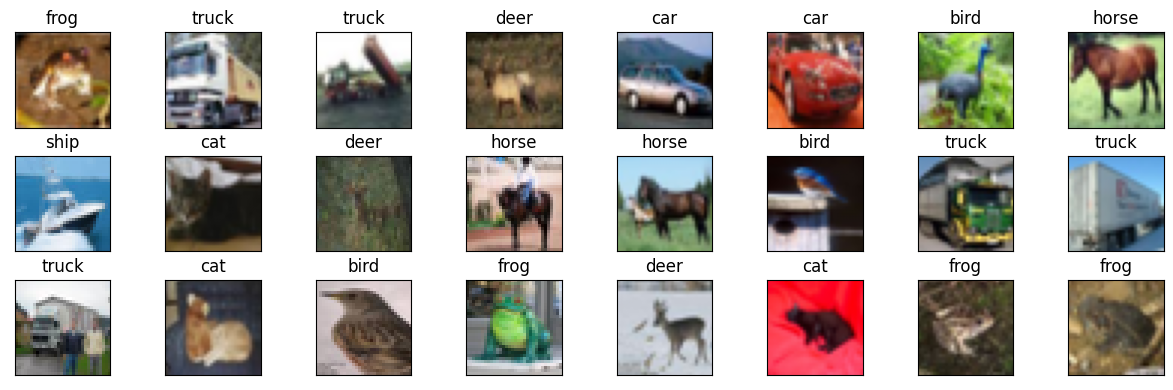

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

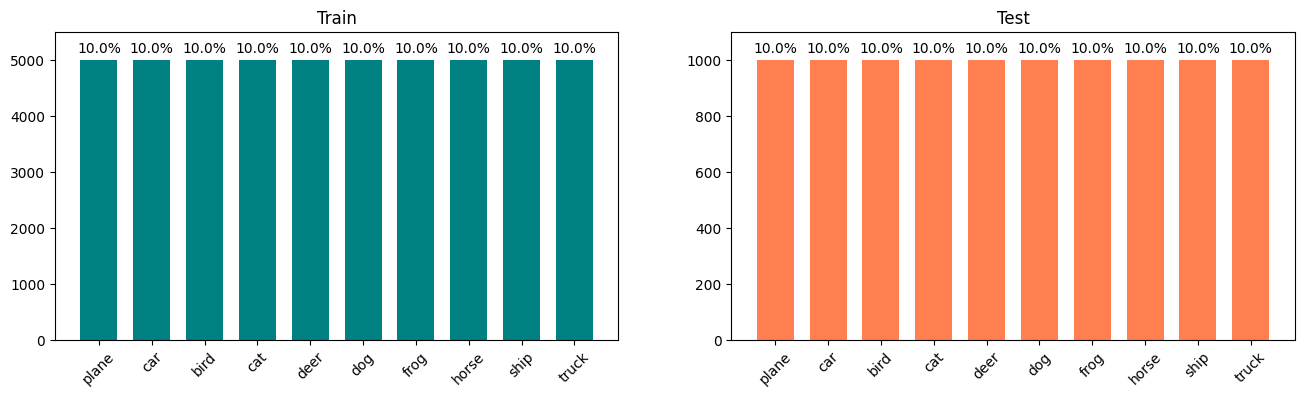

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

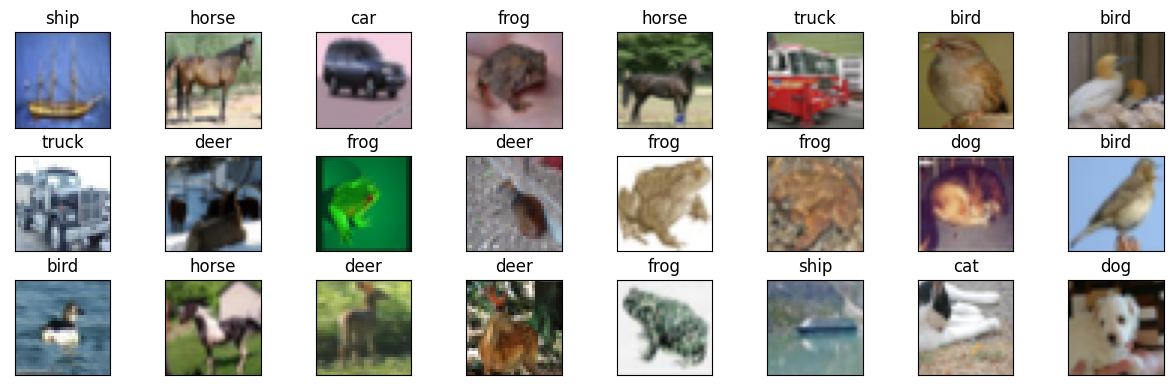

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

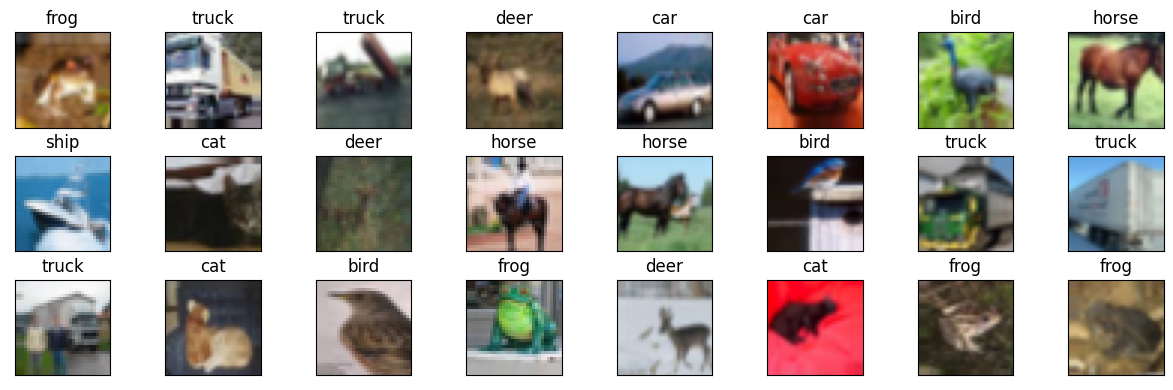

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

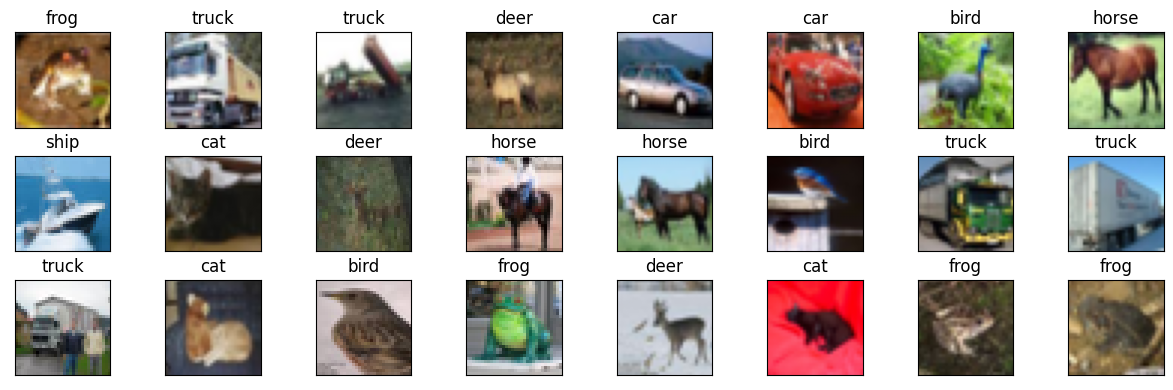

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


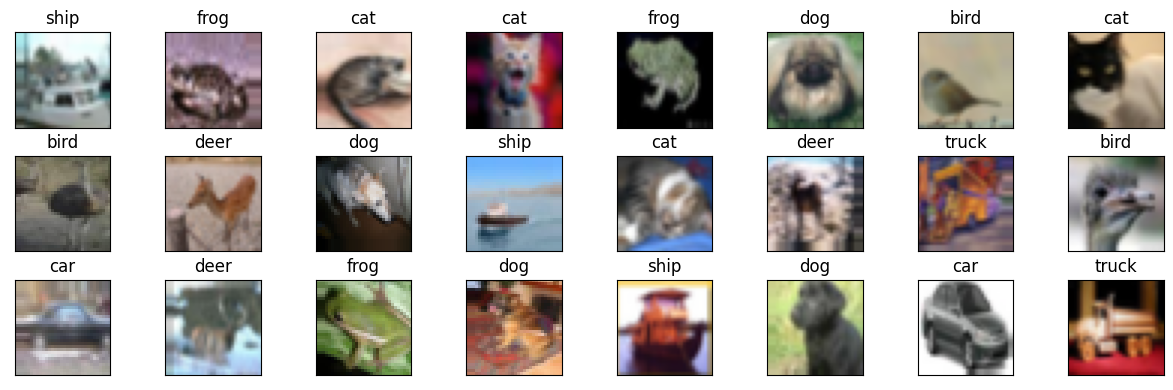

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 08:53:30,336: INFO: model_params.mlp1.dropout=0.1
2022-08-09 08:53:30,337: INFO: model_params.mlp1.layer_count=1
2022-08-09 08:53:30,337: INFO: model_params.mlp1.units=128
2022-08-09 08:53:30,375: INFO: learning_rate=0.001
2022-08-09 08:53:30,375: INFO: model_params.mlp1.clip_value=None
2022-08-09 08:53:30,383: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 08:53:30,396: INFO: model_params.mlp1.epochs=120
2022-08-09 08:53:30,396: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1, monitor=val_accuracy)
2022-08-09 08:53:30,397: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 08:53:30,398: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 08:53:30,398: INFO: use LearningRateScheduler()
2022-08-09 08:53:30,399: INFO: steps_per_epoch=1562
2022-08-09 08:53:30,400: INFO: start training
2022-08-09 08:53:30,400: INFO: use_class_weight=False


Epoch 1/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.9602 - accuracy: 0.2835INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:53:36,336: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 6s 3ms/step - loss: 1.9601 - accuracy: 0.2836 - val_loss: 1.8329 - val_accuracy: 0.3416 - lr: 0.0010
Epoch 2/120
1548/1562 [============================>.] - ETA: 0s - loss: 1.8609 - accuracy: 0.3193INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:53:41,096: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8610 - accuracy: 0.3192 - val_loss: 1.7787 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 3/120
1553/1562 [============================>.] - ETA: 0s - loss: 1.8298 - accuracy: 0.3335INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:53:45,804: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8298 - accuracy: 0.3334 - val_loss: 1.7487 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8096 - accuracy: 0.3424 - val_loss: 1.7507 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 5/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.7928 - accuracy: 0.3476INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:53:54,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7925 - accuracy: 0.3476 - val_loss: 1.7279 - val_accuracy: 0.3805 - lr: 0.0010
Epoch 6/120
1548/1562 [============================>.] - ETA: 0s - loss: 1.7815 - accuracy: 0.3520INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:53:59,487: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7816 - accuracy: 0.3519 - val_loss: 1.7100 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 7/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.7706 - accuracy: 0.3584INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:04,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7709 - accuracy: 0.3582 - val_loss: 1.6874 - val_accuracy: 0.3925 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7591 - accuracy: 0.3592 - val_loss: 1.6914 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7519 - accuracy: 0.3644 - val_loss: 1.6965 - val_accuracy: 0.3869 - lr: 0.0010
Epoch 10/120
1549/1562 [============================>.] - ETA: 0s - loss: 1.7428 - accuracy: 0.3665INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:17,394: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7426 - accuracy: 0.3663 - val_loss: 1.6870 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7332 - accuracy: 0.3708 - val_loss: 1.6905 - val_accuracy: 0.3897 - lr: 0.0010
Epoch 12/120
1543/1562 [============================>.] - ETA: 0s - loss: 1.7351 - accuracy: 0.3711INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:26,257: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7343 - accuracy: 0.3713 - val_loss: 1.6670 - val_accuracy: 0.3998 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7265 - accuracy: 0.3762 - val_loss: 1.6610 - val_accuracy: 0.3994 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7183 - accuracy: 0.3764 - val_loss: 1.6676 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 15/120
1550/1562 [============================>.] - ETA: 0s - loss: 1.7147 - accuracy: 0.3795INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:39,604: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7145 - accuracy: 0.3797 - val_loss: 1.6533 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 16/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.7141 - accuracy: 0.3779INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:44,400: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7142 - accuracy: 0.3779 - val_loss: 1.6476 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7080 - accuracy: 0.3816 - val_loss: 1.6584 - val_accuracy: 0.4022 - lr: 0.0010
Epoch 18/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.7042 - accuracy: 0.3826INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:54:53,298: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7038 - accuracy: 0.3827 - val_loss: 1.6504 - val_accuracy: 0.4073 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7004 - accuracy: 0.3852 - val_loss: 1.6496 - val_accuracy: 0.4003 - lr: 0.0010
Epoch 20/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.7000 - accuracy: 0.3854INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:55:02,226: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7002 - accuracy: 0.3853 - val_loss: 1.6437 - val_accuracy: 0.4119 - lr: 0.0010
Epoch 21/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6972 - accuracy: 0.3844 - val_loss: 1.6466 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6942 - accuracy: 0.3854 - val_loss: 1.6425 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6916 - accuracy: 0.3888 - val_loss: 1.6459 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6848 - accuracy: 0.3884 - val_loss: 1.6400 - val_accuracy: 0.4064 - lr: 0.0010
Epoch 25/120
1548/1562 [============================>.] - ETA: 0s - loss: 1.6865 - accuracy: 0.3897INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/outp

2022-08-09 08:55:23,684: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6866 - accuracy: 0.3896 - val_loss: 1.6339 - val_accuracy: 0.4133 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6841 - accuracy: 0.3918 - val_loss: 1.6382 - val_accuracy: 0.4113 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6815 - accuracy: 0.3912 - val_loss: 1.6453 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6788 - accuracy: 0.3926 - val_loss: 1.6357 - val_accuracy: 0.4121 - lr: 0.0010
Epoch 29/120
1554/1562 [============================>.] - ETA: 0s - loss: 1.6758 - accuracy: 0.3940INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:55:41,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6756 - accuracy: 0.3941 - val_loss: 1.6375 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6730 - accuracy: 0.3970 - val_loss: 1.6342 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6749 - accuracy: 0.3958 - val_loss: 1.6347 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6688 - accuracy: 0.3961 - val_loss: 1.6307 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6678 - accuracy: 0.3974 - val_loss: 1.6481 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6652 - accuracy: 0.3972 - val_loss: 1.6422 - val_accuracy: 0.4096 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 4

2022-08-09 08:57:13,228: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6376 - accuracy: 0.4084 - val_loss: 1.6193 - val_accuracy: 0.4179 - lr: 0.0010
Epoch 52/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6394 - accuracy: 0.4095 - val_loss: 1.6344 - val_accuracy: 0.4132 - lr: 0.0010
Epoch 53/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6389 - accuracy: 0.4086 - val_loss: 1.6321 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 54/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6342 - accuracy: 0.4098 - val_loss: 1.6253 - val_accuracy: 0.4129 - lr: 0.0010
Epoch 55/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6360 - accuracy: 0.4092 - val_loss: 1.6409 - val_accuracy: 0.4088 - lr: 0.0010
Epoch 56/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6361 - accuracy: 0.4105 - val_loss: 1.6144 - val_accuracy: 0.4173 - lr: 0.0010
Epoch 57/120
1562/1562 [==============================] - 4

2022-08-09 08:57:56,091: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5986 - accuracy: 0.4231 - val_loss: 1.5967 - val_accuracy: 0.4272 - lr: 1.0000e-04
Epoch 62/120
1550/1562 [============================>.] - ETA: 0s - loss: 1.5944 - accuracy: 0.4241INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:58:01,076: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5942 - accuracy: 0.4242 - val_loss: 1.5964 - val_accuracy: 0.4296 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5904 - accuracy: 0.4260 - val_loss: 1.5958 - val_accuracy: 0.4290 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5892 - accuracy: 0.4289 - val_loss: 1.5963 - val_accuracy: 0.4283 - lr: 1.0000e-04
Epoch 65/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.5884 - accuracy: 0.4268INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:58:14,111: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5886 - accuracy: 0.4267 - val_loss: 1.5961 - val_accuracy: 0.4297 - lr: 1.0000e-04
Epoch 66/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.5909 - accuracy: 0.4266INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:58:18,794: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5907 - accuracy: 0.4266 - val_loss: 1.5960 - val_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5872 - accuracy: 0.4294 - val_loss: 1.5945 - val_accuracy: 0.4285 - lr: 1.0000e-04
Epoch 68/120
1548/1562 [============================>.] - ETA: 0s - loss: 1.5863 - accuracy: 0.4299INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:58:27,677: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5859 - accuracy: 0.4299 - val_loss: 1.5962 - val_accuracy: 0.4308 - lr: 1.0000e-04
Epoch 69/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5858 - accuracy: 0.4285 - val_loss: 1.5967 - val_accuracy: 0.4297 - lr: 1.0000e-04
Epoch 70/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5881 - accuracy: 0.4284 - val_loss: 1.5964 - val_accuracy: 0.4292 - lr: 1.0000e-04
Epoch 71/120
1547/1562 [============================>.] - ETA: 0s - loss: 1.5903 - accuracy: 0.4286INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


2022-08-09 08:58:40,737: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5900 - accuracy: 0.4287 - val_loss: 1.5944 - val_accuracy: 0.4320 - lr: 1.0000e-04
Epoch 72/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5850 - accuracy: 0.4283 - val_loss: 1.5955 - val_accuracy: 0.4289 - lr: 1.0000e-04
Epoch 73/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5863 - accuracy: 0.4299 - val_loss: 1.5968 - val_accuracy: 0.4293 - lr: 1.0000e-04
Epoch 74/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5832 - accuracy: 0.4284 - val_loss: 1.5967 - val_accuracy: 0.4304 - lr: 1.0000e-04
Epoch 75/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5887 - accuracy: 0.4297 - val_loss: 1.5969 - val_accuracy: 0.4318 - lr: 1.0000e-04
Epoch 76/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.5858 - accuracy: 0.4312 - val_loss: 1.5953 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 77/120
1562/1562 [===========

2022-08-09 09:01:28,313: INFO: finish training [elapsed time: 477.91 seconds]


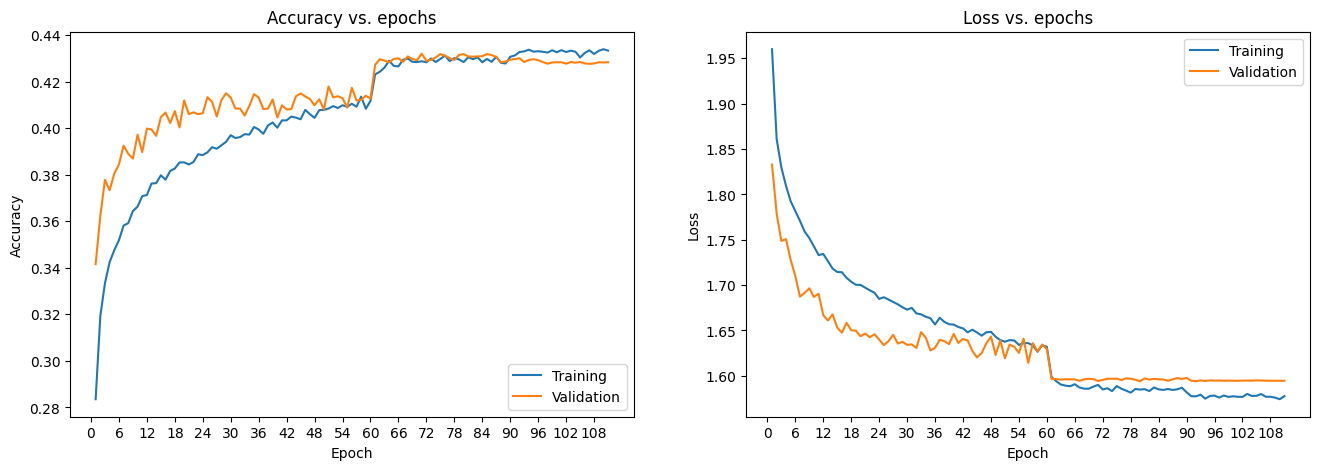

2022-08-09 09:01:28,769: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 09:01:44,972: INFO: test loss:1.5944
2022-08-09 09:01:44,973: INFO: test accuracy:0.4320
2022-08-09 09:01:44,974: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:01:44,976: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:01:44,976: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:01:44,978: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 1s 2ms/step


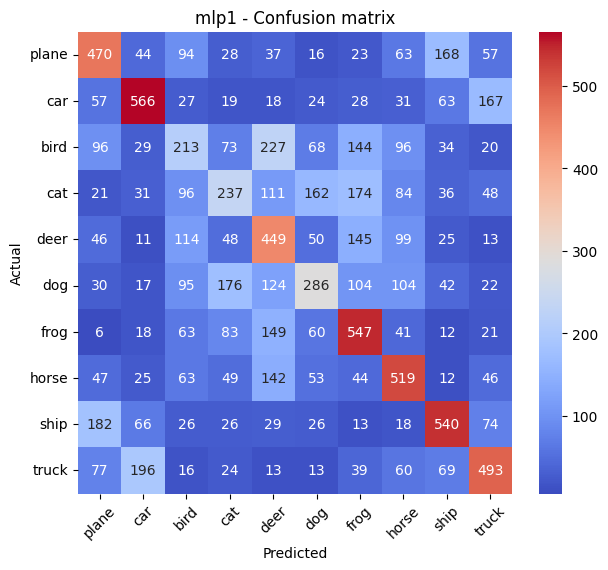

----------------------------------------sample analysis----------------------------------------
1/1 [==============================] - 0s 9ms/step


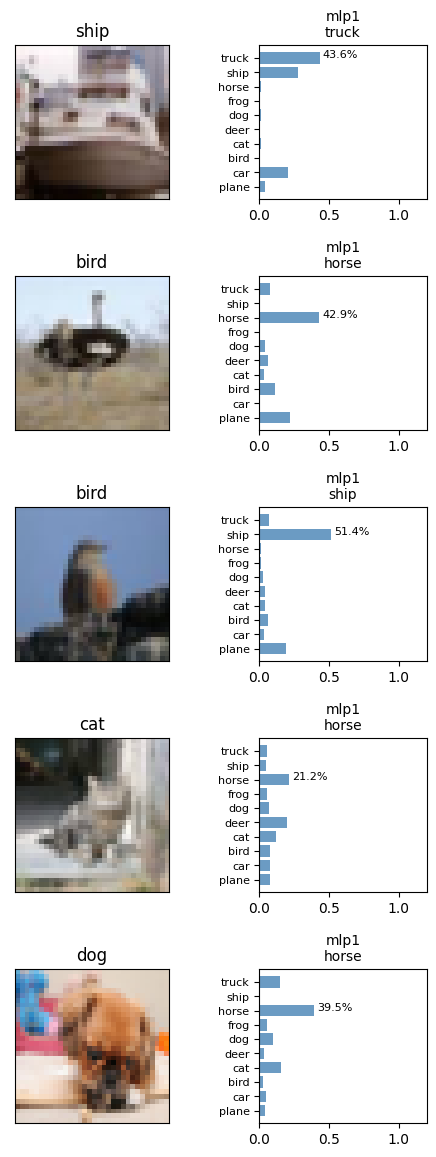

----------------------------------------models----------------------------------------


model_name             program_name  weight_number  train_time  \
1       mlp1  cifar10_0808_p100.ipynb         394634       477.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 09:01      1.4961     1.5944          0.4691          0.432   

   train_auc  test_auc  
1     0.8674    0.8462

In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 09:01:49,550: INFO: model_params.lenet1.dropout=0.2
2022-08-09 09:01:49,639: INFO: learning_rate=0.001
2022-08-09 09:01:49,639: INFO: model_params.lenet1.clip_value=None
2022-08-09 09:01:49,645: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 09:01:49,673: INFO: model_params.lenet1.epochs=120
2022-08-09 09:01:49,673: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1, monitor=val_accuracy)
2022-08-09 09:01:49,674: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:01:49,674: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:01:49,675: INFO: use LearningRateScheduler()
2022-08-09 09:01:49,676: INFO: steps_per_epoch=1562
2022-08-09 09:01:49,676: INFO: start training
2022-08-09 09:01:49,677: INFO: use_class_weight=False


Epoch 1/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.7361 - accuracy: 0.3722

2022-08-09 09:01:59,534: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:00,086: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.7352 - accuracy: 0.3726 - val_loss: 1.5090 - val_accuracy: 0.4591 - lr: 0.0010
Epoch 2/120
1553/1562 [============================>.] - ETA: 0s - loss: 1.4482 - accuracy: 0.4778

2022-08-09 09:02:08,207: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:08,761: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.4475 - accuracy: 0.4781 - val_loss: 1.3229 - val_accuracy: 0.5193 - lr: 0.0010
Epoch 3/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.3437 - accuracy: 0.5179

2022-08-09 09:02:17,439: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:17,989: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.3434 - accuracy: 0.5180 - val_loss: 1.2928 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 4/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.2677 - accuracy: 0.5483

2022-08-09 09:02:26,119: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:26,675: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.2679 - accuracy: 0.5483 - val_loss: 1.2581 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 5/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.2059 - accuracy: 0.5721

2022-08-09 09:02:34,750: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:35,318: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.2057 - accuracy: 0.5723 - val_loss: 1.1045 - val_accuracy: 0.6031 - lr: 0.0010
Epoch 6/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.1615 - accuracy: 0.5892 - val_loss: 1.2624 - val_accuracy: 0.5631 - lr: 0.0010
Epoch 7/120
1553/1562 [============================>.] - ETA: 0s - loss: 1.1295 - accuracy: 0.6017

2022-08-09 09:02:50,675: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:02:51,251: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.1284 - accuracy: 0.6020 - val_loss: 1.0862 - val_accuracy: 0.6178 - lr: 0.0010
Epoch 8/120
1552/1562 [============================>.] - ETA: 0s - loss: 1.1002 - accuracy: 0.6117

2022-08-09 09:02:59,741: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:03:00,305: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0997 - accuracy: 0.6119 - val_loss: 1.0490 - val_accuracy: 0.6311 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.6204

2022-08-09 09:03:08,726: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:03:09,281: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0727 - accuracy: 0.6204 - val_loss: 1.0008 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0551 - accuracy: 0.6281 - val_loss: 1.0180 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 11/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.0363 - accuracy: 0.6352

2022-08-09 09:03:24,640: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:03:25,205: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 1.0361 - accuracy: 0.6352 - val_loss: 0.9528 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 7s 4ms/step - loss: 1.0166 - accuracy: 0.6408 - val_loss: 0.9763 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 7s 5ms/step - loss: 1.0064 - accuracy: 0.6476 - val_loss: 0.9698 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9884 - accuracy: 0.6513 - val_loss: 1.0732 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9800 - accuracy: 0.6541 - val_loss: 1.0012 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9648 - accuracy: 0.6602 - val_loss: 0.9648 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 17/120
1557/1562 [============================>.] - E

2022-08-09 09:04:08,475: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:04:09,042: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9517 - accuracy: 0.6649 - val_loss: 0.9278 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9506 - accuracy: 0.6628 - val_loss: 0.9649 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9412 - accuracy: 0.6671 - val_loss: 0.9725 - val_accuracy: 0.6568 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.9362 - accuracy: 0.6696 - val_loss: 1.0141 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 21/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.9266 - accuracy: 0.6760

2022-08-09 09:04:39,120: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:04:39,669: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9262 - accuracy: 0.6762 - val_loss: 0.9135 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9227 - accuracy: 0.6761 - val_loss: 0.9309 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 23/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.6805

2022-08-09 09:04:55,027: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:04:55,581: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.9100 - accuracy: 0.6806 - val_loss: 0.9012 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.9067 - accuracy: 0.6810 - val_loss: 0.9159 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 25/120
1551/1562 [============================>.] - ETA: 0s - loss: 0.8990 - accuracy: 0.6835

2022-08-09 09:05:10,685: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:05:11,251: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8984 - accuracy: 0.6835 - val_loss: 0.8993 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8882 - accuracy: 0.6889 - val_loss: 1.0311 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8922 - accuracy: 0.6849 - val_loss: 0.9623 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 28/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.6847

2022-08-09 09:05:33,327: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:05:33,867: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8854 - accuracy: 0.6847 - val_loss: 0.8839 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8812 - accuracy: 0.6894 - val_loss: 0.9199 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8773 - accuracy: 0.6916 - val_loss: 0.9030 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.6916

2022-08-09 09:05:56,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:05:57,181: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8716 - accuracy: 0.6916 - val_loss: 0.8710 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8671 - accuracy: 0.6930 - val_loss: 0.9126 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 33/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.8651 - accuracy: 0.6954

2022-08-09 09:06:12,360: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:06:12,926: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8645 - accuracy: 0.6958 - val_loss: 0.8633 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8580 - accuracy: 0.6976 - val_loss: 0.9220 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8593 - accuracy: 0.6983 - val_loss: 0.9628 - val_accuracy: 0.6691 - lr: 0.0010
Epoch 36/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8582 - accuracy: 0.6964 - val_loss: 0.9100 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8592 - accuracy: 0.6971 - val_loss: 0.9193 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8441 - accuracy: 0.7028 - val_loss: 0.9099 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 7

2022-08-09 09:07:17,039: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:07:17,601: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8357 - accuracy: 0.7028 - val_loss: 0.8537 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 43/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8317 - accuracy: 0.7065 - val_loss: 0.8888 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 44/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8269 - accuracy: 0.7071 - val_loss: 0.9193 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 45/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8281 - accuracy: 0.7085 - val_loss: 0.8797 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 46/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8286 - accuracy: 0.7076 - val_loss: 0.8760 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 47/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8235 - accuracy: 0.7093 - val_loss: 0.8815 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 48/120
1562/1562 [==============================] - 7

2022-08-09 09:08:50,103: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:08:50,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.8098 - accuracy: 0.7142 - val_loss: 0.8472 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 56/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8057 - accuracy: 0.7158 - val_loss: 0.9014 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 57/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.8076 - accuracy: 0.7141 - val_loss: 0.9002 - val_accuracy: 0.6899 - lr: 0.0010
Epoch 58/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8055 - accuracy: 0.7136 - val_loss: 0.9286 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 59/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8031 - accuracy: 0.7159 - val_loss: 0.9684 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 60/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.8030 - accuracy: 0.7168 - val_loss: 0.8591 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate t

2022-08-09 09:09:34,326: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:09:34,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7636 - accuracy: 0.7295 - val_loss: 0.8116 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7571 - accuracy: 0.7323 - val_loss: 0.8271 - val_accuracy: 0.7175 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7530 - accuracy: 0.7333 - val_loss: 0.8201 - val_accuracy: 0.7195 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7495 - accuracy: 0.7352 - val_loss: 0.8160 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 65/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.7477 - accuracy: 0.7373

2022-08-09 09:10:03,884: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:10:04,430: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7475 - accuracy: 0.7374 - val_loss: 0.8161 - val_accuracy: 0.7228 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7411 - accuracy: 0.7374 - val_loss: 0.8229 - val_accuracy: 0.7194 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7437 - accuracy: 0.7365 - val_loss: 0.8177 - val_accuracy: 0.7198 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7407 - accuracy: 0.7392 - val_loss: 0.8137 - val_accuracy: 0.7221 - lr: 1.0000e-04
Epoch 69/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7400 - accuracy: 0.7370 - val_loss: 0.8119 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 70/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.7447 - accuracy: 0.7360

2022-08-09 09:10:40,808: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:10:41,647: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7439 - accuracy: 0.7363 - val_loss: 0.8082 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 71/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7406 - accuracy: 0.7387 - val_loss: 0.8106 - val_accuracy: 0.7226 - lr: 1.0000e-04
Epoch 72/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7375 - accuracy: 0.7402 - val_loss: 0.8129 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 73/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7330 - accuracy: 0.7400 - val_loss: 0.8257 - val_accuracy: 0.7181 - lr: 1.0000e-04
Epoch 74/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7362 - accuracy: 0.7378 - val_loss: 0.8157 - val_accuracy: 0.7181 - lr: 1.0000e-04
Epoch 75/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.7388 - accuracy: 0.7381

2022-08-09 09:11:18,133: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:11:18,694: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7382 - accuracy: 0.7383 - val_loss: 0.8082 - val_accuracy: 0.7237 - lr: 1.0000e-04
Epoch 76/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7283 - accuracy: 0.7426 - val_loss: 0.8288 - val_accuracy: 0.7181 - lr: 1.0000e-04
Epoch 77/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7317 - accuracy: 0.7414 - val_loss: 0.8216 - val_accuracy: 0.7205 - lr: 1.0000e-04
Epoch 78/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7332 - accuracy: 0.7415 - val_loss: 0.8130 - val_accuracy: 0.7215 - lr: 1.0000e-04
Epoch 79/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7352 - accuracy: 0.7390 - val_loss: 0.8093 - val_accuracy: 0.7223 - lr: 1.0000e-04
Epoch 80/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7317 - accuracy: 0.7378 - val_loss: 0.8166 - val_accuracy: 0.7197 - lr: 1.0000e-04
Epoch 81/120
1562/1562 [===========

2022-08-09 09:12:09,353: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:12:09,914: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7314 - accuracy: 0.7386 - val_loss: 0.8047 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 83/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7258 - accuracy: 0.7414 - val_loss: 0.8241 - val_accuracy: 0.7202 - lr: 1.0000e-04
Epoch 84/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7345 - accuracy: 0.7372 - val_loss: 0.8129 - val_accuracy: 0.7189 - lr: 1.0000e-04
Epoch 85/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7325 - accuracy: 0.7410 - val_loss: 0.8177 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 86/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7263 - accuracy: 0.7437 - val_loss: 0.8137 - val_accuracy: 0.7225 - lr: 1.0000e-04
Epoch 87/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7324 - accuracy: 0.7403 - val_loss: 0.8121 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 88/120
1562/1562 [===========

2022-08-09 09:13:14,336: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:13:14,899: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7196 - accuracy: 0.7425 - val_loss: 0.8065 - val_accuracy: 0.7239 - lr: 1.0000e-05
Epoch 92/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.7237 - accuracy: 0.7428

2022-08-09 09:13:23,458: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:13:24,031: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7237 - accuracy: 0.7428 - val_loss: 0.8066 - val_accuracy: 0.7240 - lr: 1.0000e-05
Epoch 93/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7233 - accuracy: 0.7456 - val_loss: 0.8095 - val_accuracy: 0.7231 - lr: 1.0000e-05
Epoch 94/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7257 - accuracy: 0.7417 - val_loss: 0.8079 - val_accuracy: 0.7228 - lr: 1.0000e-05
Epoch 95/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.7225 - accuracy: 0.7440

2022-08-09 09:13:46,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:13:46,865: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7226 - accuracy: 0.7440 - val_loss: 0.8065 - val_accuracy: 0.7250 - lr: 1.0000e-05
Epoch 96/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7209 - accuracy: 0.7433 - val_loss: 0.8081 - val_accuracy: 0.7238 - lr: 1.0000e-05
Epoch 97/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.7248 - accuracy: 0.7437
Epoch 97: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7247 - accuracy: 0.7437 - val_loss: 0.8062 - val_accuracy: 0.7247 - lr: 3.1623e-06
Epoch 00098: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 98/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.7162 - accuracy: 0.7440

2022-08-09 09:14:09,112: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:14:09,673: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7159 - accuracy: 0.7441 - val_loss: 0.8057 - val_accuracy: 0.7251 - lr: 3.1623e-06
Epoch 00099: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 99/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7209 - accuracy: 0.7456 - val_loss: 0.8065 - val_accuracy: 0.7243 - lr: 3.1623e-06
Epoch 00100: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 100/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7230 - accuracy: 0.7428 - val_loss: 0.8067 - val_accuracy: 0.7248 - lr: 3.1623e-06
Epoch 00101: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 101/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7197 - accuracy: 0.7455 - val_loss: 0.8062 - val_accuracy: 0.7245 - lr: 3.1623e-06
Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7227 - accuracy: 0.7427 - 

2022-08-09 09:14:45,971: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


2022-08-09 09:14:46,547: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1/assets


1562/1562 [==============================] - 9s 6ms/step - loss: 0.7214 - accuracy: 0.7439 - val_loss: 0.8049 - val_accuracy: 0.7253 - lr: 3.1623e-06
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
1562/1562 [==============================] - 7s 5ms/step - loss: 0.7211 - accuracy: 0.7424 - val_loss: 0.8067 - val_accuracy: 0.7251 - lr: 3.1623e-06
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7175 - accuracy: 0.7443 - val_loss: 0.8064 - val_accuracy: 0.7248 - lr: 3.1623e-06
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epoch 106/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7215 - accuracy: 0.7464 - val_loss: 0.8062 - val_accuracy: 0.7248 - lr: 1.0000e-06
Epoch 107/120
1562/1562 [==============================] - 7s 4ms/step - loss: 0.7142 - accuracy: 0.7460 - val_loss: 0.8066 - val_accuracy: 0.7250 - lr

2022-08-09 09:16:46,116: INFO: finish training [elapsed time: 896.44 seconds]


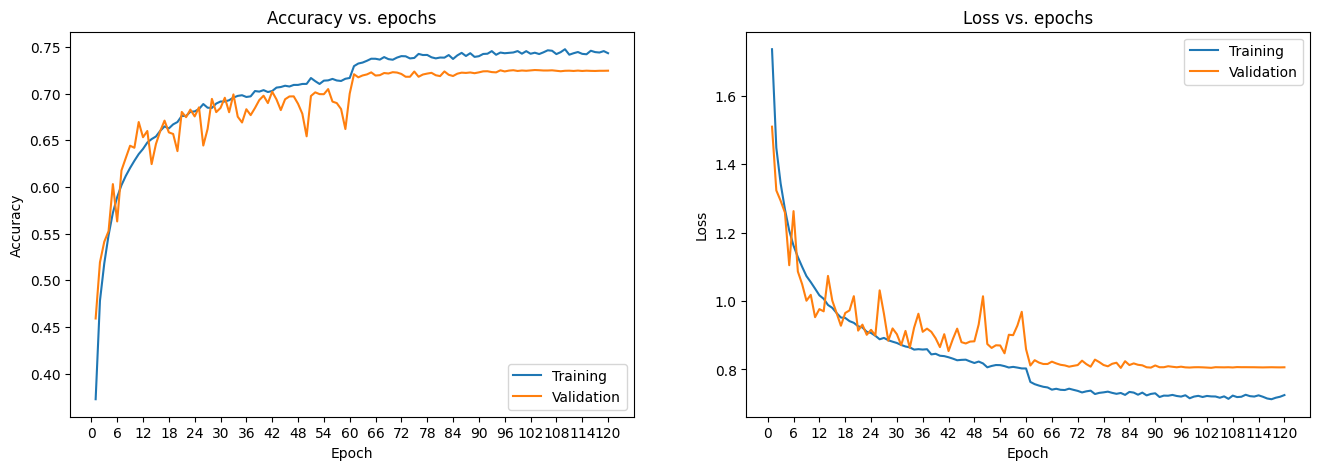

2022-08-09 09:16:46,534: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 09:17:05,453: INFO: test loss:0.8049
2022-08-09 09:17:05,453: INFO: test accuracy:0.7253
2022-08-09 09:17:05,455: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:17:05,456: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:17:05,457: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:17:05,458: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:17:05,459: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 09:17:05,747: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


313/313 [==============================] - 1s 2ms/step


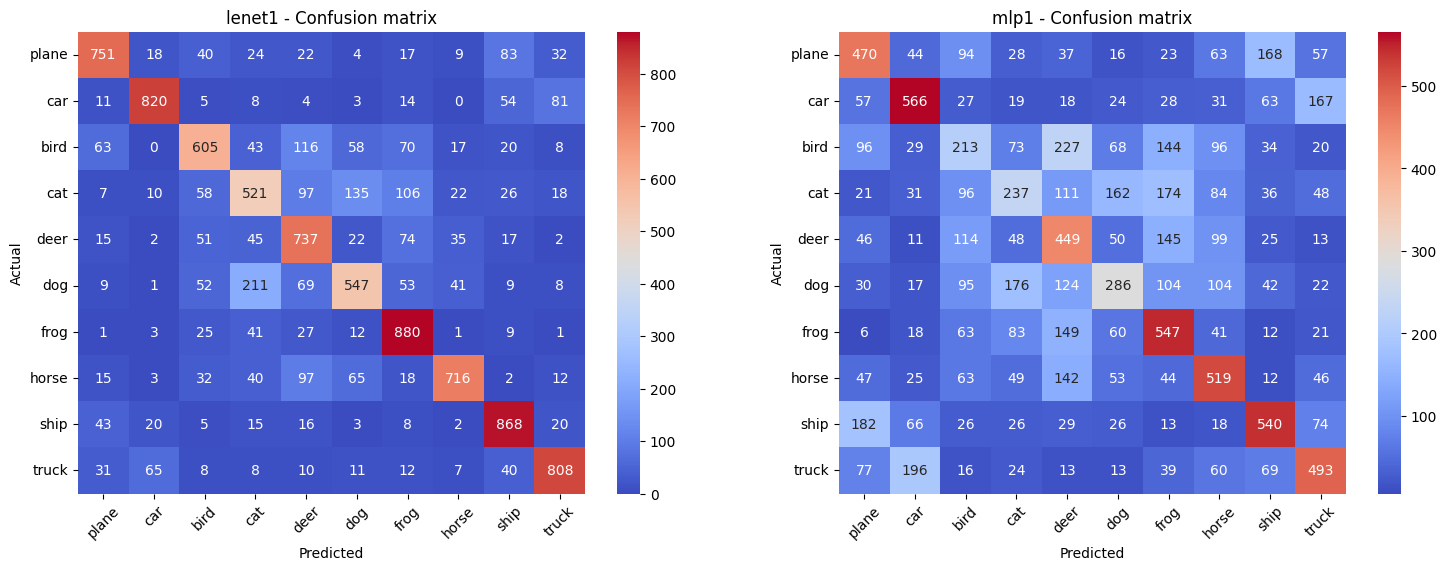

2022-08-09 09:17:09,989: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-09 09:17:10,274: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


1/1 [==============================] - 0s 9ms/step


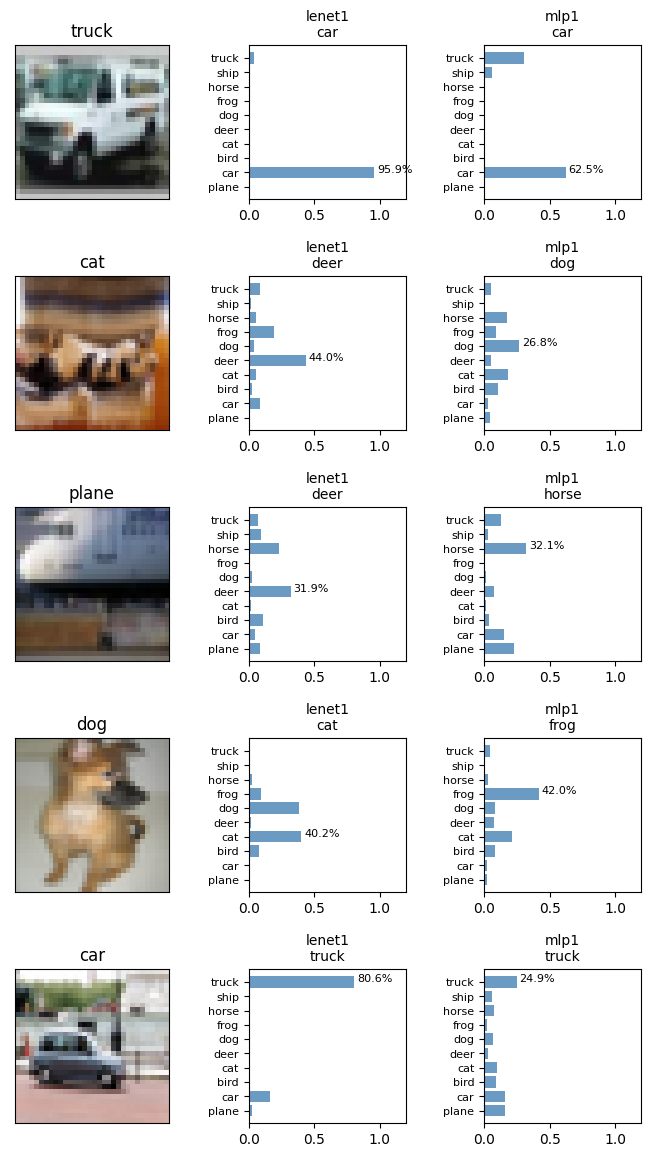

----------------------------------------models----------------------------------------


model_name             program_name  weight_number  train_time  \
1     lenet1  cifar10_0808_p100.ipynb          83170       896.4   
2       mlp1  cifar10_0808_p100.ipynb         394634       477.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 09:17      0.4781     0.8049          0.8339         0.7253   
2  2022-08-09 09:01      1.4961     1.5944          0.4691         0.4320   

   train_auc  test_auc  
1     0.9865    0.9614  
2     0.8674    0.8462

In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 09:17:13,978: INFO: model_params.custom1.dropout=0.2
2022-08-09 09:17:14,084: INFO: learning_rate=0.001
2022-08-09 09:17:14,086: INFO: model_params.custom1.clip_value=None
2022-08-09 09:17:14,093: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 09:17:14,138: INFO: model_params.custom1.epochs=120
2022-08-09 09:17:14,139: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1, monitor=val_accuracy)
2022-08-09 09:17:14,140: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:17:14,141: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:17:14,142: INFO: use LearningRateScheduler()
2022-08-09 09:17:14,143: INFO: steps_per_epoch=1562
2022-08-09 09:17:14,144: INFO: start training
2022-08-09 09:17:14,144: INFO: use_class_weight=False


Epoch 1/120
1552/1562 [============================>.] - ETA: 0s - loss: 1.5980 - accuracy: 0.4274

2022-08-09 09:17:24,493: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:17:25,131: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.5966 - accuracy: 0.4280 - val_loss: 1.3397 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 2/120
1553/1562 [============================>.] - ETA: 0s - loss: 1.2591 - accuracy: 0.5517

2022-08-09 09:17:34,674: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:17:35,320: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 1.2582 - accuracy: 0.5521 - val_loss: 1.1207 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 3/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1352 - accuracy: 0.5978 - val_loss: 1.2354 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0593 - accuracy: 0.6259 - val_loss: 1.3111 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 5/120
1554/1562 [============================>.] - ETA: 0s - loss: 1.0066 - accuracy: 0.6477

2022-08-09 09:18:00,833: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:18:01,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.0059 - accuracy: 0.6480 - val_loss: 0.9316 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 6/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.9652 - accuracy: 0.6631

2022-08-09 09:18:10,743: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:18:11,393: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9650 - accuracy: 0.6631 - val_loss: 0.8773 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9276 - accuracy: 0.6769 - val_loss: 0.9861 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9015 - accuracy: 0.6843 - val_loss: 0.8796 - val_accuracy: 0.6966 - lr: 0.0010
Epoch 9/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.8762 - accuracy: 0.6949

2022-08-09 09:18:37,108: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:18:37,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.8756 - accuracy: 0.6950 - val_loss: 0.8291 - val_accuracy: 0.7071 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8615 - accuracy: 0.6964 - val_loss: 0.9524 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.7069

2022-08-09 09:18:55,515: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:18:56,143: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.8448 - accuracy: 0.7069 - val_loss: 0.7909 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8296 - accuracy: 0.7095 - val_loss: 0.9733 - val_accuracy: 0.6693 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8124 - accuracy: 0.7155 - val_loss: 0.8514 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7985 - accuracy: 0.7211 - val_loss: 0.8101 - val_accuracy: 0.7198 - lr: 0.0010
Epoch 15/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.7915 - accuracy: 0.7252

2022-08-09 09:19:30,147: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:19:30,755: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7916 - accuracy: 0.7252 - val_loss: 0.7624 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7847 - accuracy: 0.7255 - val_loss: 0.8357 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7701 - accuracy: 0.7305 - val_loss: 0.8264 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 18/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.7660 - accuracy: 0.7318

2022-08-09 09:19:56,462: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:19:57,106: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7659 - accuracy: 0.7319 - val_loss: 0.7517 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7558 - accuracy: 0.7361 - val_loss: 0.8384 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7503 - accuracy: 0.7374 - val_loss: 0.7668 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 21/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7450 - accuracy: 0.7397 - val_loss: 0.9801 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7325 - accuracy: 0.7457 - val_loss: 0.7948 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7308 - accuracy: 0.7434 - val_loss: 0.7984 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 24/120
1554/1562 [============================>.] - 

2022-08-09 09:20:46,178: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:20:46,798: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7214 - accuracy: 0.7485 - val_loss: 0.6978 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7186 - accuracy: 0.7487 - val_loss: 0.7752 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7164 - accuracy: 0.7504 - val_loss: 0.9776 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7031 - accuracy: 0.7521 - val_loss: 0.8865 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7025 - accuracy: 0.7545 - val_loss: 0.7789 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 29/120
1554/1562 [============================>.] - ETA: 0s - loss: 0.6987 - accuracy: 0.7564

2022-08-09 09:21:27,965: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:21:28,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6984 - accuracy: 0.7565 - val_loss: 0.6859 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6977 - accuracy: 0.7553 - val_loss: 0.7053 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6910 - accuracy: 0.7576 - val_loss: 0.7425 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6842 - accuracy: 0.7615 - val_loss: 0.7210 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6846 - accuracy: 0.7607 - val_loss: 0.7706 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 34/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.7628

2022-08-09 09:22:12,174: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:22:12,815: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6763 - accuracy: 0.7630 - val_loss: 0.6681 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6753 - accuracy: 0.7650 - val_loss: 0.7331 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 36/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6774 - accuracy: 0.7621 - val_loss: 0.7572 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6742 - accuracy: 0.7634 - val_loss: 0.7154 - val_accuracy: 0.7558 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6694 - accuracy: 0.7657 - val_loss: 0.8612 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6657 - accuracy: 0.7684 - val_loss: 0.7188 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 40/120
1562/1562 [==============================] - 

2022-08-09 09:23:28,627: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:23:29,279: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.6473 - accuracy: 0.7728 - val_loss: 0.6537 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 44/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6539 - accuracy: 0.7719 - val_loss: 0.6717 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 45/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6462 - accuracy: 0.7726 - val_loss: 0.6871 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 46/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6431 - accuracy: 0.7772 - val_loss: 0.7172 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 47/120
1562/1562 [==============================] - 11s 7ms/step - loss: 0.6450 - accuracy: 0.7733 - val_loss: 0.7476 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 48/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6385 - accuracy: 0.7766 - val_loss: 0.7110 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 49/120
1562/1562 [==============================] -

2022-08-09 09:25:42,971: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:25:43,633: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.5868 - accuracy: 0.7931 - val_loss: 0.6465 - val_accuracy: 0.7808 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.5697 - accuracy: 0.7997

2022-08-09 09:25:52,978: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


2022-08-09 09:25:53,619: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.5696 - accuracy: 0.7998 - val_loss: 0.5942 - val_accuracy: 0.8009 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5688 - accuracy: 0.7998 - val_loss: 0.5971 - val_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5670 - accuracy: 0.8010 - val_loss: 0.6027 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5608 - accuracy: 0.8029 - val_loss: 0.6102 - val_accuracy: 0.7948 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5551 - accuracy: 0.8054 - val_loss: 0.6051 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.5582 - accuracy: 0.8054 - val_los

2022-08-09 09:31:23,503: INFO: finish training [elapsed time: 849.36 seconds]


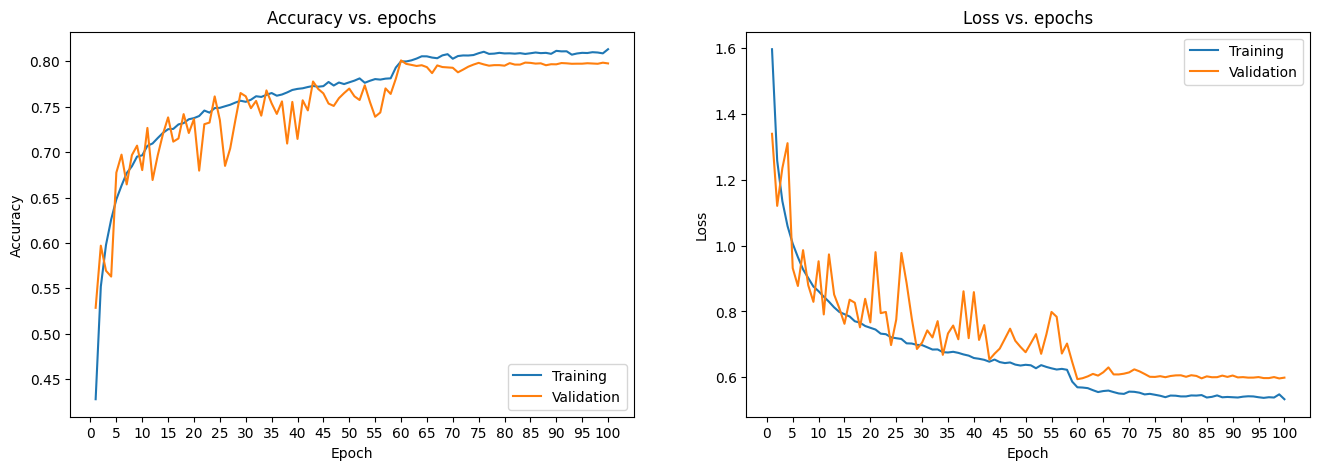

2022-08-09 09:31:24,044: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 09:31:45,354: INFO: test loss:0.5942
2022-08-09 09:31:45,354: INFO: test accuracy:0.8009
2022-08-09 09:31:45,356: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:31:45,358: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 09:31:45,359: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:31:45,360: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:31:45,361: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 09:31:46,313: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


313/313 [==============================] - 1s 2ms/step


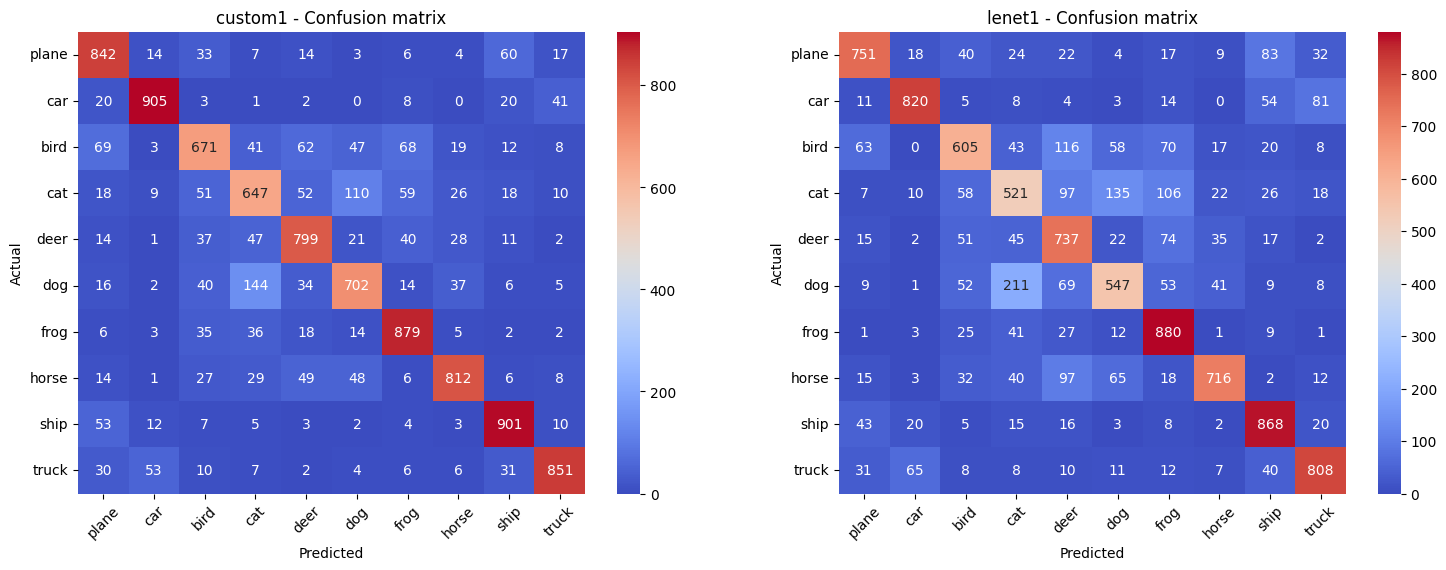

2022-08-09 09:31:51,750: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 09:31:52,686: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 09:31:52,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1
2022-08-09 09:31:53,018: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


1/1 [==============================] - 0s 10ms/step


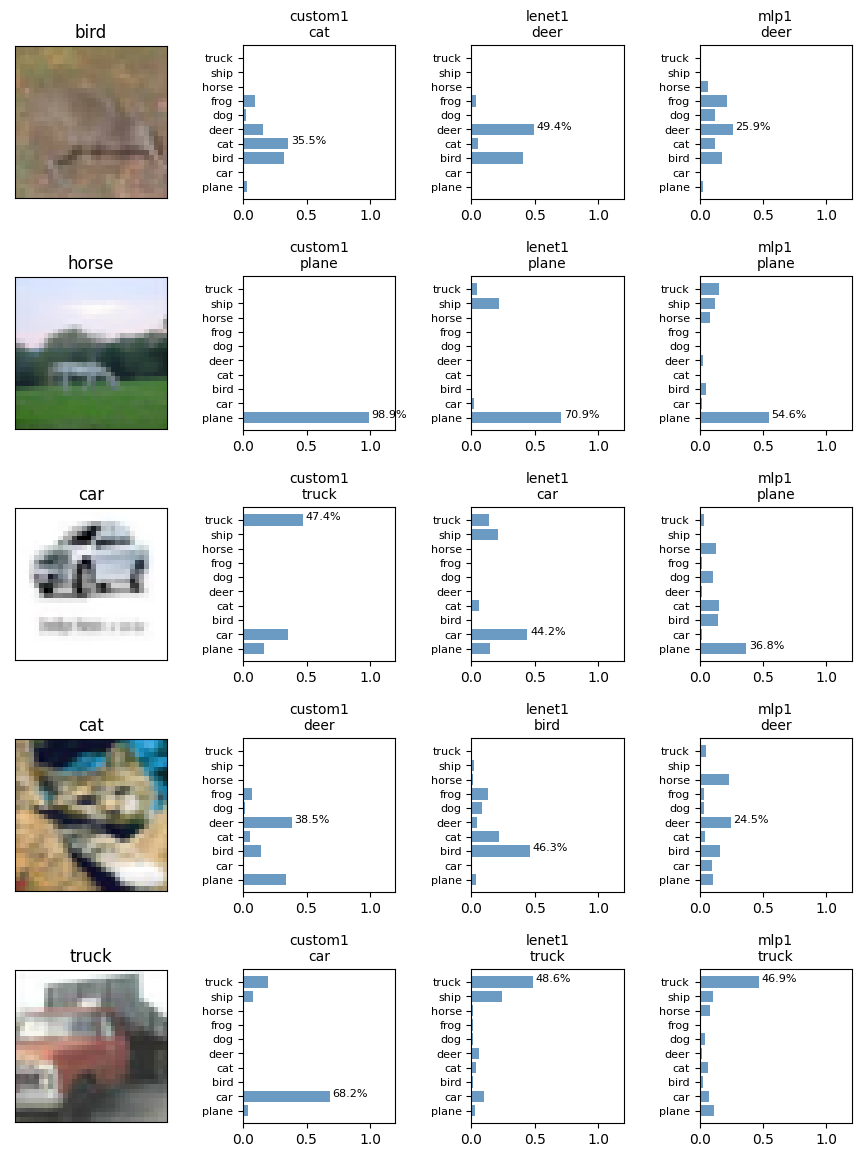

----------------------------------------models----------------------------------------


model_name             program_name  weight_number  train_time  \
1    custom1  cifar10_0808_p100.ipynb          73738       849.4   
2     lenet1  cifar10_0808_p100.ipynb          83170       896.4   
3       mlp1  cifar10_0808_p100.ipynb         394634       477.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
2  2022-08-09 09:17      0.4781     0.8049          0.8339         0.7253   
3  2022-08-09 09:01      1.4961     1.5944          0.4691         0.4320   

   train_auc  test_auc  
1     0.9926    0.9778  
2     0.9865    0.9614  
3     0.8674    0.8462

In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 09:31:57,844: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 09:31:58,025: INFO: learning_rate=0.001
2022-08-09 09:31:58,026: INFO: model_params.vgg8.clip_value=None
2022-08-09 09:31:58,032: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 09:31:58,080: INFO: model_params.vgg8.epochs=120
2022-08-09 09:31:58,081: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8, monitor=val_accuracy)
2022-08-09 09:31:58,082: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:31:58,082: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:31:58,083: INFO: use LearningRateScheduler()
2022-08-09 09:31:58,084: INFO: steps_per_epoch=1562
2022-08-09 09:31:58,084: INFO: start training
2022-08-09 09:31:58,085: INFO: use_class_weight=False


Epoch 1/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.9895 - accuracy: 0.2233

2022-08-09 09:32:19,833: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:32:20,918: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 1.9892 - accuracy: 0.2235 - val_loss: 1.6400 - val_accuracy: 0.3876 - lr: 0.0010
Epoch 2/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.7843 - accuracy: 0.2994

2022-08-09 09:32:40,812: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:32:41,895: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 1.7841 - accuracy: 0.2995 - val_loss: 1.4294 - val_accuracy: 0.4681 - lr: 0.0010
Epoch 3/120
1562/1562 [==============================] - ETA: 0s - loss: 1.6930 - accuracy: 0.3292

2022-08-09 09:33:02,150: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:33:03,277: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 1.6930 - accuracy: 0.3292 - val_loss: 1.3696 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 4/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.6274 - accuracy: 0.3536

2022-08-09 09:33:24,496: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:33:25,582: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.6273 - accuracy: 0.3537 - val_loss: 1.2282 - val_accuracy: 0.5363 - lr: 0.0010
Epoch 5/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.5507 - accuracy: 0.3896

2022-08-09 09:33:46,338: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:33:47,465: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.5508 - accuracy: 0.3896 - val_loss: 1.1781 - val_accuracy: 0.5743 - lr: 0.0010
Epoch 6/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.4751 - accuracy: 0.4298

2022-08-09 09:34:08,836: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:34:09,948: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.4749 - accuracy: 0.4299 - val_loss: 1.1024 - val_accuracy: 0.5931 - lr: 0.0010
Epoch 7/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.3546 - accuracy: 0.4893

2022-08-09 09:34:30,897: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:34:32,350: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.3544 - accuracy: 0.4895 - val_loss: 1.0123 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - ETA: 0s - loss: 1.2272 - accuracy: 0.5486

2022-08-09 09:34:53,331: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:34:54,457: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.2272 - accuracy: 0.5486 - val_loss: 0.8941 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0784 - accuracy: 0.6062 - val_loss: 0.8987 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.6392

2022-08-09 09:35:34,307: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:35:35,410: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.9882 - accuracy: 0.6392 - val_loss: 0.7300 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 11/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.8479 - accuracy: 0.7022

2022-08-09 09:35:56,588: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:35:57,751: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.8478 - accuracy: 0.7022 - val_loss: 0.6371 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.7649 - accuracy: 0.7323 - val_loss: 0.6647 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.7172 - accuracy: 0.7496 - val_loss: 0.7325 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 14/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.7732

2022-08-09 09:36:56,436: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:36:57,518: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.6625 - accuracy: 0.7732 - val_loss: 0.5561 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 15/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.7904

2022-08-09 09:37:18,732: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:37:19,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.6181 - accuracy: 0.7905 - val_loss: 0.5615 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.5545 - accuracy: 0.8148 - val_loss: 0.5414 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 17/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.8293

2022-08-09 09:37:59,763: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:38:00,865: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.5143 - accuracy: 0.8294 - val_loss: 0.5188 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.4763 - accuracy: 0.8418 - val_loss: 0.5783 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 19/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.4436 - accuracy: 0.8523

2022-08-09 09:38:40,710: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:38:41,837: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.4435 - accuracy: 0.8523 - val_loss: 0.5269 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.4234 - accuracy: 0.8589 - val_loss: 0.5313 - val_accuracy: 0.8379 - lr: 0.0010
Epoch 21/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8662

2022-08-09 09:39:21,895: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:39:23,049: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.4000 - accuracy: 0.8663 - val_loss: 0.5222 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.3776 - accuracy: 0.8736 - val_loss: 0.5655 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.3646 - accuracy: 0.8773 - val_loss: 0.5530 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.8856

2022-08-09 09:40:21,234: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:40:22,665: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3423 - accuracy: 0.8856 - val_loss: 0.5485 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 25/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8903

2022-08-09 09:40:43,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:40:44,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3256 - accuracy: 0.8903 - val_loss: 0.4965 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.3166 - accuracy: 0.8914 - val_loss: 0.5585 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 27/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8983

2022-08-09 09:41:24,256: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:41:25,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3036 - accuracy: 0.8984 - val_loss: 0.4871 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2927 - accuracy: 0.8995 - val_loss: 0.5846 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2847 - accuracy: 0.9037 - val_loss: 0.5263 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 30/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.9072

2022-08-09 09:42:23,886: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:42:25,018: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.2745 - accuracy: 0.9072 - val_loss: 0.4845 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2617 - accuracy: 0.9124 - val_loss: 0.5950 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 32/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2477 - accuracy: 0.9149 - val_loss: 0.5355 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2478 - accuracy: 0.9156 - val_loss: 0.5465 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2439 - accuracy: 0.9186 - val_loss: 0.5023 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 35/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9214

2022-08-09 09:44:01,030: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:44:02,175: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 0.2317 - accuracy: 0.9214 - val_loss: 0.4908 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 36/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2239 - accuracy: 0.9243 - val_loss: 0.5470 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2173 - accuracy: 0.9263 - val_loss: 0.5497 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2199 - accuracy: 0.9262 - val_loss: 0.6343 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2089 - accuracy: 0.9286 - val_loss: 0.5102 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 40/120
1562/1562 [==============================] - 18s 11ms/step - loss: 0.2089 - accuracy: 0.9305 - val_loss: 0.5182 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 41/120
1562/1562 [=======================

2022-08-09 09:46:51,136: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:46:52,247: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 15ms/step - loss: 0.1902 - accuracy: 0.9354 - val_loss: 0.5099 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 45/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9367
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1889 - accuracy: 0.9367 - val_loss: 0.5118 - val_accuracy: 0.8722 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9514

2022-08-09 09:47:34,121: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:47:35,259: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 15ms/step - loss: 0.1438 - accuracy: 0.9514 - val_loss: 0.5070 - val_accuracy: 0.8832 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1280 - accuracy: 0.9567 - val_loss: 0.5499 - val_accuracy: 0.8769 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9598

2022-08-09 09:48:16,253: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:48:17,379: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 0.1158 - accuracy: 0.9598 - val_loss: 0.5284 - val_accuracy: 0.8868 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9611

2022-08-09 09:48:39,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:48:40,896: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 0.1142 - accuracy: 0.9611 - val_loss: 0.5131 - val_accuracy: 0.8882 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1154 - accuracy: 0.9612 - val_loss: 0.5115 - val_accuracy: 0.8875 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.9652

2022-08-09 09:49:22,491: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:49:23,666: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 15ms/step - loss: 0.1024 - accuracy: 0.9651 - val_loss: 0.5283 - val_accuracy: 0.8899 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1031 - accuracy: 0.9642 - val_loss: 0.5351 - val_accuracy: 0.8881 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0950 - accuracy: 0.9674 - val_loss: 0.5526 - val_accuracy: 0.8856 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0947 - accuracy: 0.9682 - val_loss: 0.5462 - val_accuracy: 0.8858 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 

2022-08-09 09:50:45,627: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:50:46,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 23s 15ms/step - loss: 0.0933 - accuracy: 0.9681 - val_loss: 0.5438 - val_accuracy: 0.8907 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0940 - accuracy: 0.9682 - val_loss: 0.5512 - val_accuracy: 0.8877 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.0905 - accuracy: 0.9698

2022-08-09 09:51:29,609: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:51:30,775: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 0.0905 - accuracy: 0.9698 - val_loss: 0.5505 - val_accuracy: 0.8910 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0918 - accuracy: 0.9683 - val_loss: 0.5500 - val_accuracy: 0.8883 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0875 - accuracy: 0.9708 - val_loss: 0.5440 - val_accuracy: 0.8860 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9711
Epoch 60: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0845 - accuracy: 0.9711 - val_loss: 0.5599 - val_accuracy: 0.8887 - lr: 1.00

2022-08-09 09:53:51,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:53:52,831: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 0.0641 - accuracy: 0.9783 - val_loss: 0.5735 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0678 - accuracy: 0.9773 - val_loss: 0.5613 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0650 - accuracy: 0.9784 - val_loss: 0.5674 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0636 - accuracy: 0.9779 - val_loss: 0.5821 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0635 - accuracy: 0.9780 - val_loss: 0.5761 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 69/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0620 - accuracy: 0.9795 - val_loss: 0.5828 - val_accuracy: 0.8921 - lr: 1.0000e-04
Epoch 70/120
1559/1562 

2022-08-09 09:55:55,047: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:55:56,188: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 0.0640 - accuracy: 0.9789 - val_loss: 0.5741 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 71/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0629 - accuracy: 0.9790 - val_loss: 0.5864 - val_accuracy: 0.8907 - lr: 1.0000e-04
Epoch 72/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0607 - accuracy: 0.9803 - val_loss: 0.5880 - val_accuracy: 0.8921 - lr: 1.0000e-04
Epoch 73/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0615 - accuracy: 0.9796 - val_loss: 0.5889 - val_accuracy: 0.8903 - lr: 1.0000e-04
Epoch 74/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.0584 - accuracy: 0.9798 - val_loss: 0.5878 - val_accuracy: 0.8903 - lr: 1.0000e-04
Epoch 75/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9802

2022-08-09 09:57:38,691: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:57:39,952: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets



Epoch 75: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0590 - accuracy: 0.9803 - val_loss: 0.5801 - val_accuracy: 0.8938 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9808

2022-08-09 09:58:02,906: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:58:04,043: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 0.0580 - accuracy: 0.9808 - val_loss: 0.5827 - val_accuracy: 0.8944 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9818

2022-08-09 09:58:25,016: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 09:58:26,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.0550 - accuracy: 0.9818 - val_loss: 0.5826 - val_accuracy: 0.8945 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0560 - accuracy: 0.9811 - val_loss: 0.5882 - val_accuracy: 0.8935 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0563 - accuracy: 0.9816 - val_loss: 0.5892 - val_accuracy: 0.8942 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0534 - accuracy: 0.9819 - val_loss: 0.5931 - val_accuracy: 0.8926 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0565 - accu

2022-08-09 10:00:54,012: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 10:00:55,097: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 31s 20ms/step - loss: 0.0552 - accuracy: 0.9819 - val_loss: 0.5888 - val_accuracy: 0.8951 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0557 - accuracy: 0.9807 - val_loss: 0.5928 - val_accuracy: 0.8940 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9831

2022-08-09 10:01:48,099: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


2022-08-09 10:01:49,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8/assets


1562/1562 [==============================] - 28s 18ms/step - loss: 0.0508 - accuracy: 0.9831 - val_loss: 0.5896 - val_accuracy: 0.8968 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
1562/1562 [==============================] - 24s 16ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.5905 - val_accuracy: 0.8946 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.5900 - val_accuracy: 0.8956 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/120
1562/1562 [==============================] - 26s 17ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.5963 - val_accuracy: 0.8944 - lr: 3.1623e-05
Epoch 00089: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 89/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.0507 - accu

2022-08-09 10:17:57,050: INFO: finish training [elapsed time: 2758.97 seconds]


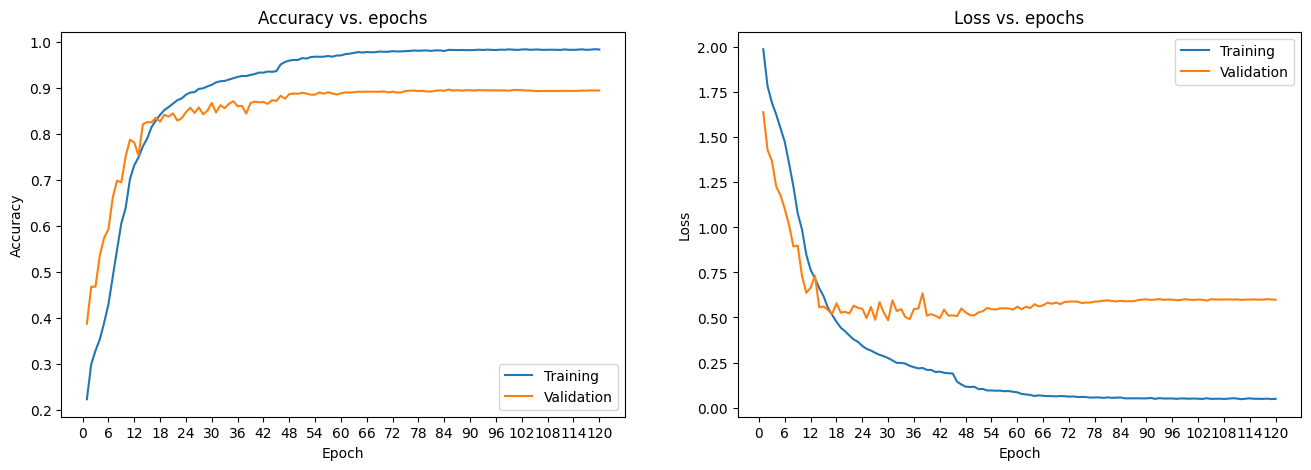

2022-08-09 10:17:57,538: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 4ms/step


2022-08-09 10:18:26,884: INFO: test loss:0.5896
2022-08-09 10:18:26,885: INFO: test accuracy:0.8968
2022-08-09 10:18:26,887: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 10:18:26,890: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 10:18:26,891: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 10:18:26,892: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 10:18:26,893: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 10:18:27,962: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


313/313 [==============================] - 1s 3ms/step


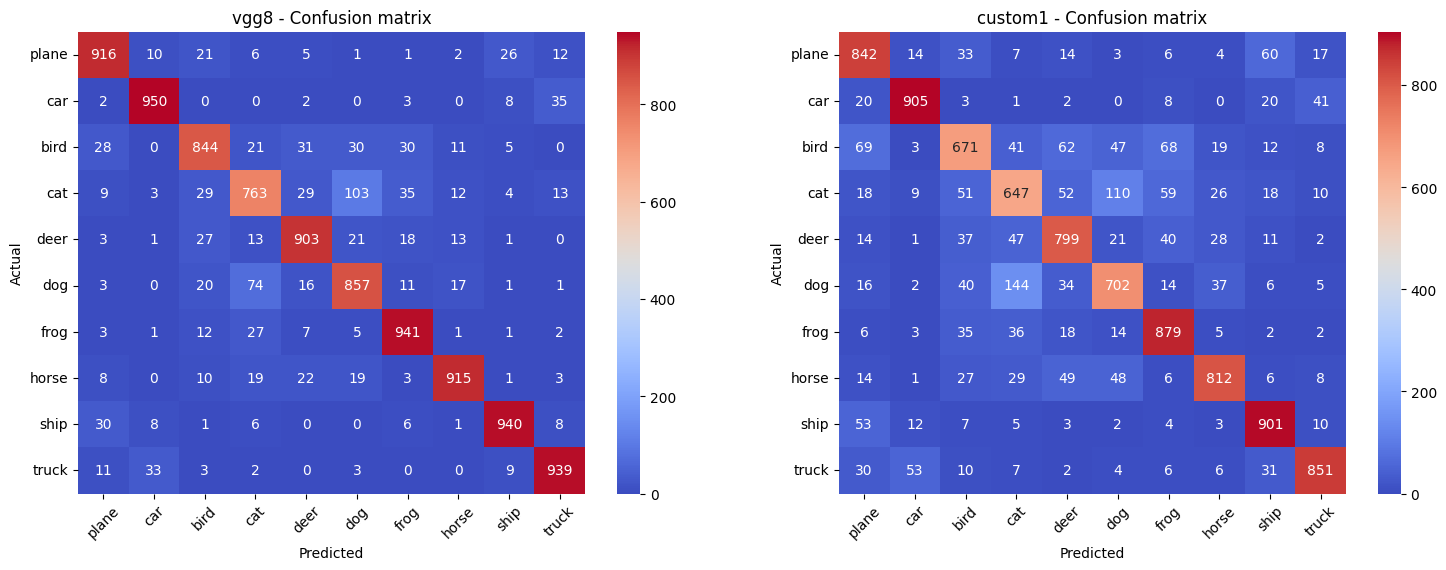

2022-08-09 10:18:33,868: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 10:18:34,927: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 10:18:34,932: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1
2022-08-09 10:18:35,805: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 10:18:35,808: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/mlp1
2022-08-09 10:18:36,126: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


1/1 [==============================] - 0s 10ms/step


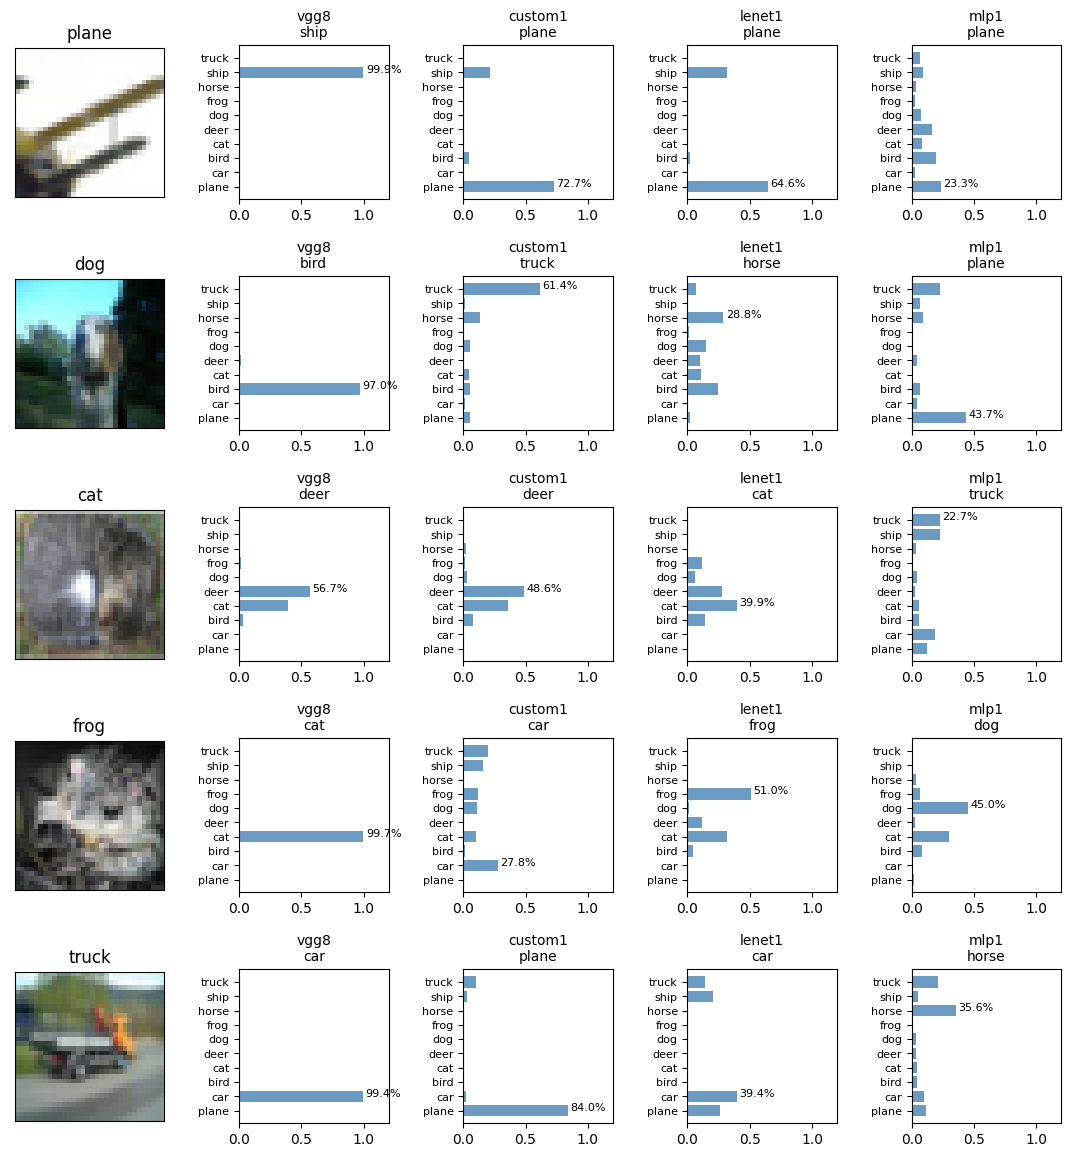

----------------------------------------models----------------------------------------


model_name             program_name  weight_number  train_time  \
1       vgg8  cifar10_0808_p100.ipynb        1672906      2759.0   
2    custom1  cifar10_0808_p100.ipynb          73738       849.4   
3     lenet1  cifar10_0808_p100.ipynb          83170       896.4   
4       mlp1  cifar10_0808_p100.ipynb         394634       477.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2  2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
3  2022-08-09 09:17      0.4781     0.8049          0.8339         0.7253   
4  2022-08-09 09:01      1.4961     1.5944          0.4691         0.4320   

   train_auc  test_auc  
1     1.0000    0.9922  
2     0.9926    0.9778  
3     0.9865    0.9614  
4     0.8674    0.8462

In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 10:18:43,043: INFO: learning_rate=0.001
2022-08-09 10:18:43,044: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 10:18:43,051: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 10:18:43,170: INFO: model_params.resnet_v1_20.epochs=120
2022-08-09 10:18:43,171: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20, monitor=val_accuracy)
2022-08-09 10:18:43,171: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 10:18:43,172: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 10:18:43,172: INFO: use LearningRateScheduler()
2022-08-09 10:18:43,173: INFO: steps_per_epoch=1562
2022-08-09 10:18:43,174: INFO: start training
2022-08-09 10:18:43,174: INFO: use_class_weight=False


Epoch 1/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.4768 - accuracy: 0.5225

2022-08-09 10:19:37,114: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:19:40,204: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 57s 34ms/step - loss: 1.4765 - accuracy: 0.5226 - val_loss: 1.4448 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 2/120
1562/1562 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.6734

2022-08-09 10:20:29,840: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:20:33,121: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 53s 34ms/step - loss: 1.0796 - accuracy: 0.6734 - val_loss: 1.3106 - val_accuracy: 0.6072 - lr: 0.0010
Epoch 3/120
1562/1562 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.7388

2022-08-09 10:21:22,297: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:21:25,815: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 53s 34ms/step - loss: 0.9044 - accuracy: 0.7388 - val_loss: 1.0661 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 4/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.7966 - accuracy: 0.7813

2022-08-09 10:22:14,650: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:22:17,725: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 52s 33ms/step - loss: 0.7964 - accuracy: 0.7814 - val_loss: 1.0016 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 5/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.7168 - accuracy: 0.8140 - val_loss: 1.2168 - val_accuracy: 0.6765 - lr: 0.0010
Epoch 6/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.6580 - accuracy: 0.8372 - val_loss: 1.1376 - val_accuracy: 0.7066 - lr: 0.0010
Epoch 7/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.6129 - accuracy: 0.8571

2022-08-09 10:23:57,628: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:24:00,543: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 42s 27ms/step - loss: 0.6127 - accuracy: 0.8571 - val_loss: 1.0985 - val_accuracy: 0.7329 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5740 - accuracy: 0.8748 - val_loss: 1.3412 - val_accuracy: 0.6978 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5485 - accuracy: 0.8874 - val_loss: 1.2357 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.5262 - accuracy: 0.8988 - val_loss: 1.2684 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.5127 - accuracy: 0.9062 - val_loss: 1.2772 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.4974 - accuracy: 0.9150 - val_loss: 1.5838 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 13/120
1562/1562 [=========================

2022-08-09 10:30:04,492: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:30:07,684: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 42s 27ms/step - loss: 0.4648 - accuracy: 0.9384 - val_loss: 1.4658 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 19/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.4678 - accuracy: 0.9384
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 33s 21ms/step - loss: 0.4677 - accuracy: 0.9385 - val_loss: 1.4699 - val_accuracy: 0.7295 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.3772 - accuracy: 0.9730

2022-08-09 10:31:21,492: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:31:24,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 44s 28ms/step - loss: 0.3771 - accuracy: 0.9730 - val_loss: 1.2197 - val_accuracy: 0.8021 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.9958

2022-08-09 10:32:06,016: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:32:09,096: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 45s 29ms/step - loss: 0.3046 - accuracy: 0.9958 - val_loss: 1.2646 - val_accuracy: 0.8027 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.2745 - accuracy: 0.9981 - val_loss: 1.6203 - val_accuracy: 0.7691 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.2851 - accuracy: 0.9872 - val_loss: 1.3742 - val_accuracy: 0.7902 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.2613 - accuracy: 0.9933 - val_loss: 1.4201 - val_accuracy: 0.7936 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2530 - accu

2022-08-09 10:40:05,875: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:40:09,274: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 45s 29ms/step - loss: 0.1961 - accuracy: 0.9967 - val_loss: 1.3690 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9999

2022-08-09 10:40:47,697: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:40:50,811: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 42s 27ms/step - loss: 0.1832 - accuracy: 0.9999 - val_loss: 1.3638 - val_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1751 - accuracy: 1.0000 - val_loss: 1.3858 - val_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1610 - accuracy: 1.0000 - val_loss: 1.4120 - val_accuracy: 0.8069 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1363 - accuracy: 1.0000 - val_loss: 1.4515 - val_accuracy: 0.8030 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1250 - accuracy: 0.9961

2022-08-09 10:54:15,031: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:54:17,906: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.3374 - accuracy: 0.9704 - val_loss: 0.9918 - val_accuracy: 0.8226 - lr: 1.0000e-04
Epoch 62/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.9929

2022-08-09 10:54:51,376: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:54:54,553: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 37s 23ms/step - loss: 0.2783 - accuracy: 0.9929 - val_loss: 1.0483 - val_accuracy: 0.8241 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 27s 17ms/step - loss: 0.2533 - accuracy: 0.9993 - val_loss: 1.1164 - val_accuracy: 0.8229 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9999

2022-08-09 10:55:55,316: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:55:59,012: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 38s 24ms/step - loss: 0.2352 - accuracy: 0.9999 - val_loss: 1.1823 - val_accuracy: 0.8251 - lr: 1.0000e-04
Epoch 65/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2138 - accuracy: 1.0000

2022-08-09 10:56:34,797: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:56:38,478: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets



Epoch 65: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 39s 25ms/step - loss: 0.2138 - accuracy: 1.0000 - val_loss: 1.2439 - val_accuracy: 0.8252 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/120
1562/1562 [==============================] - 29s 18ms/step - loss: 0.1946 - accuracy: 1.0000 - val_loss: 1.2663 - val_accuracy: 0.8247 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
1562/1562 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 1.0000

2022-08-09 10:57:42,687: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:57:45,793: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 39s 25ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 1.2880 - val_accuracy: 0.8253 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.1579 - accuracy: 1.0000 - val_loss: 1.3145 - val_accuracy: 0.8251 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
1562/1562 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 1.0000

2022-08-09 10:58:49,765: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:58:53,075: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 39s 25ms/step - loss: 0.1338 - accuracy: 1.0000 - val_loss: 1.3445 - val_accuracy: 0.8259 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 1.0000

2022-08-09 10:59:31,412: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


2022-08-09 10:59:34,837: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20/assets


1562/1562 [==============================] - 42s 27ms/step - loss: 0.1099 - accuracy: 1.0000 - val_loss: 1.3800 - val_accuracy: 0.8262 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.0883 - accuracy: 1.0000 - val_loss: 1.4347 - val_accuracy: 0.8235 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.0713 - accuracy: 0.9998 - val_loss: 1.6443 - val_accuracy: 0.8109 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.0663 - accuracy: 0.9998 - val_loss: 1.4980 - val_accuracy: 0.8225 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.0648 - accu

1562/1562 [==============================] - 28s 18ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 1.9007 - val_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 107/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 1.9045 - val_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 108/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 1.9081 - val_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 109/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 1.9116 - val_accuracy: 0.8132 - lr: 1.0000e-06
Epoch 110/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 1.0000
Epoch 110: ReduceLROnPlateau reducing learning rate to 5e-07.
1562/1562 [==============================] - 28s 18ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 1.9151 - val_accuracy: 0.8134 - lr: 5.0000e-07
Epoch 110: early stopping


2022-08-09 11:19:15,105: INFO: finish training [elapsed time: 3631.93 seconds]


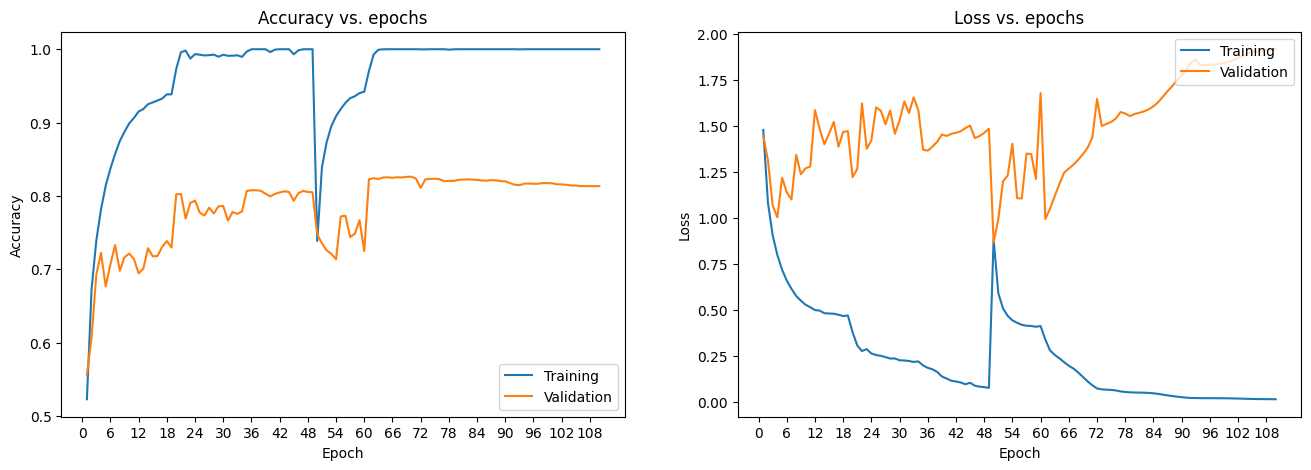

2022-08-09 11:19:15,537: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 11:19:53,189: INFO: test loss:1.3800
2022-08-09 11:19:53,189: INFO: test accuracy:0.8262
2022-08-09 11:19:53,193: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 11:19:53,195: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/results.json
2022-08-09 11:19:53,196: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:19:53,197: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:19:53,197: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 11:19:54,750: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator


313/313 [==============================] - 1s 3ms/step


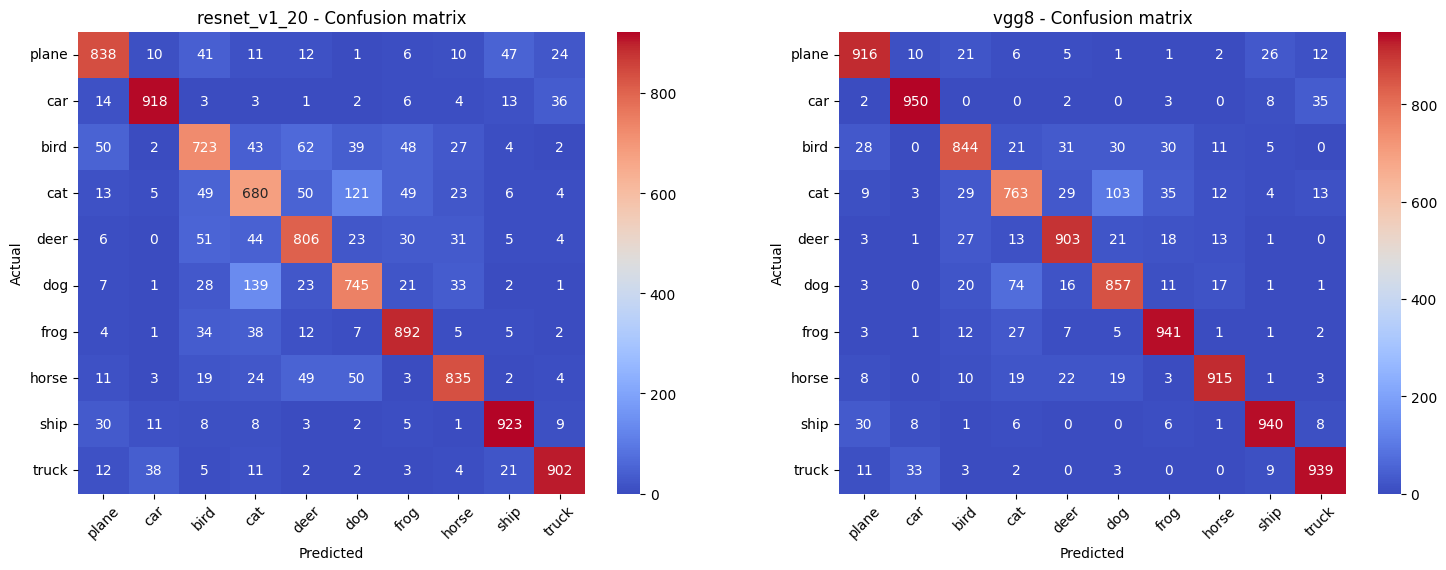

2022-08-09 11:20:00,734: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 11:20:02,251: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:20:02,263: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/custom1
2022-08-09 11:20:03,164: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:20:03,169: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/lenet1
2022-08-09 11:20:04,473: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:20:04,478: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensor

1/1 [==============================] - 0s 114ms/step


2022-08-09 11:20:08,254: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f17bc0d05e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 9ms/step


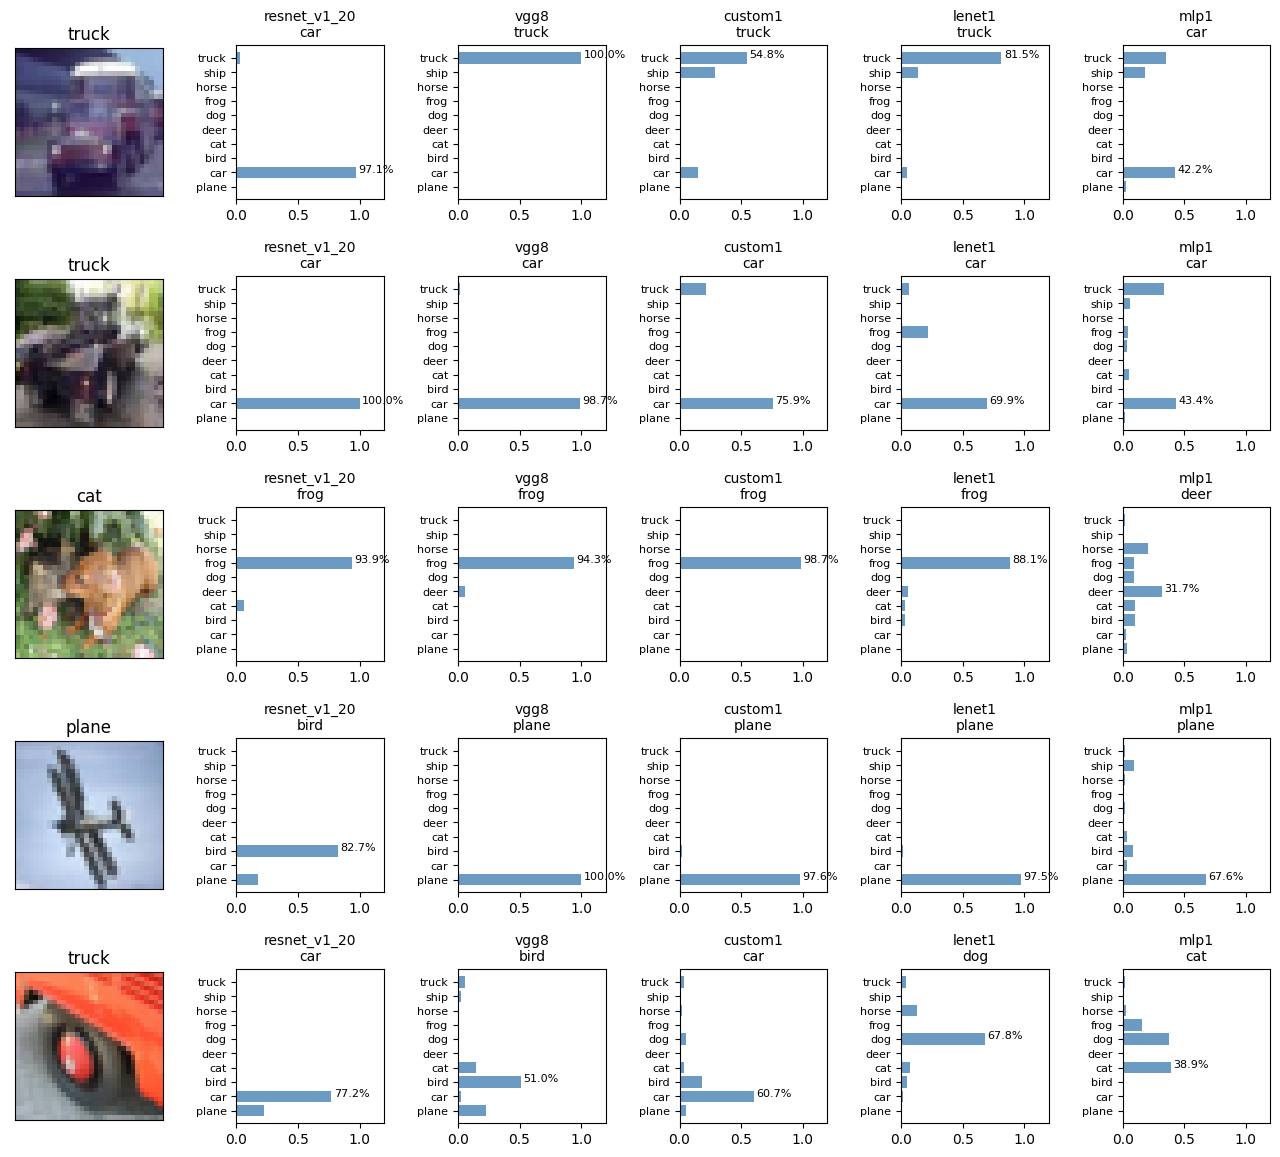

----------------------------------------models----------------------------------------


model_name             program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_p100.ipynb        1672906      2759.0   
2  resnet_v1_20  cifar10_0808_p100.ipynb         273066      3631.9   
3       custom1  cifar10_0808_p100.ipynb          73738       849.4   
4        lenet1  cifar10_0808_p100.ipynb          83170       896.4   
5          mlp1  cifar10_0808_p100.ipynb         394634       477.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2  2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
3  2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
4  2022-08-09 09:17      0.4781     0.8049          0.8339         0.7253   
5  2022-08-09 09:01      1.4961     1.5944          0.4691         0.4320   

   train_auc  test_auc  
1     1.0000    0.9922  
2     1.0000    0.9796  
3     0.9926    0.9778  
4     0.9865    0.9614  
5     0.8674    0.8462

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [22]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 11:20:11,970: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 11:20:11,972: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 11:20:11,973: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 11:20:11,974: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 11:20:11,975: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 11:20:11,976: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20        cifar10_0808_p100.ipynb         273066      3631.9   
6   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
7   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
8        custom1        cifar10_0808_p100.ipynb          73738       849.4   
9        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
10       custom1        cifar10_0721_p100.ipynb          73738      1190.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
6   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
7   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
8   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
9   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
10  2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9796  
6      1.0000    0.9810  
7      1.0000    0.9791  
8      0.9926    0.9778  
9      0.9934    0.9776  
10     0.9929    0.9776

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 11:20:12,054: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 11:20:13,590: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 11:20:13,598: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 11:20:15,990: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 11:20:15,999: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 11:20:17,503: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 180ms/step


2022-08-09 11:20:24,586: WARNING: 5 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f17849fd280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 13ms/step


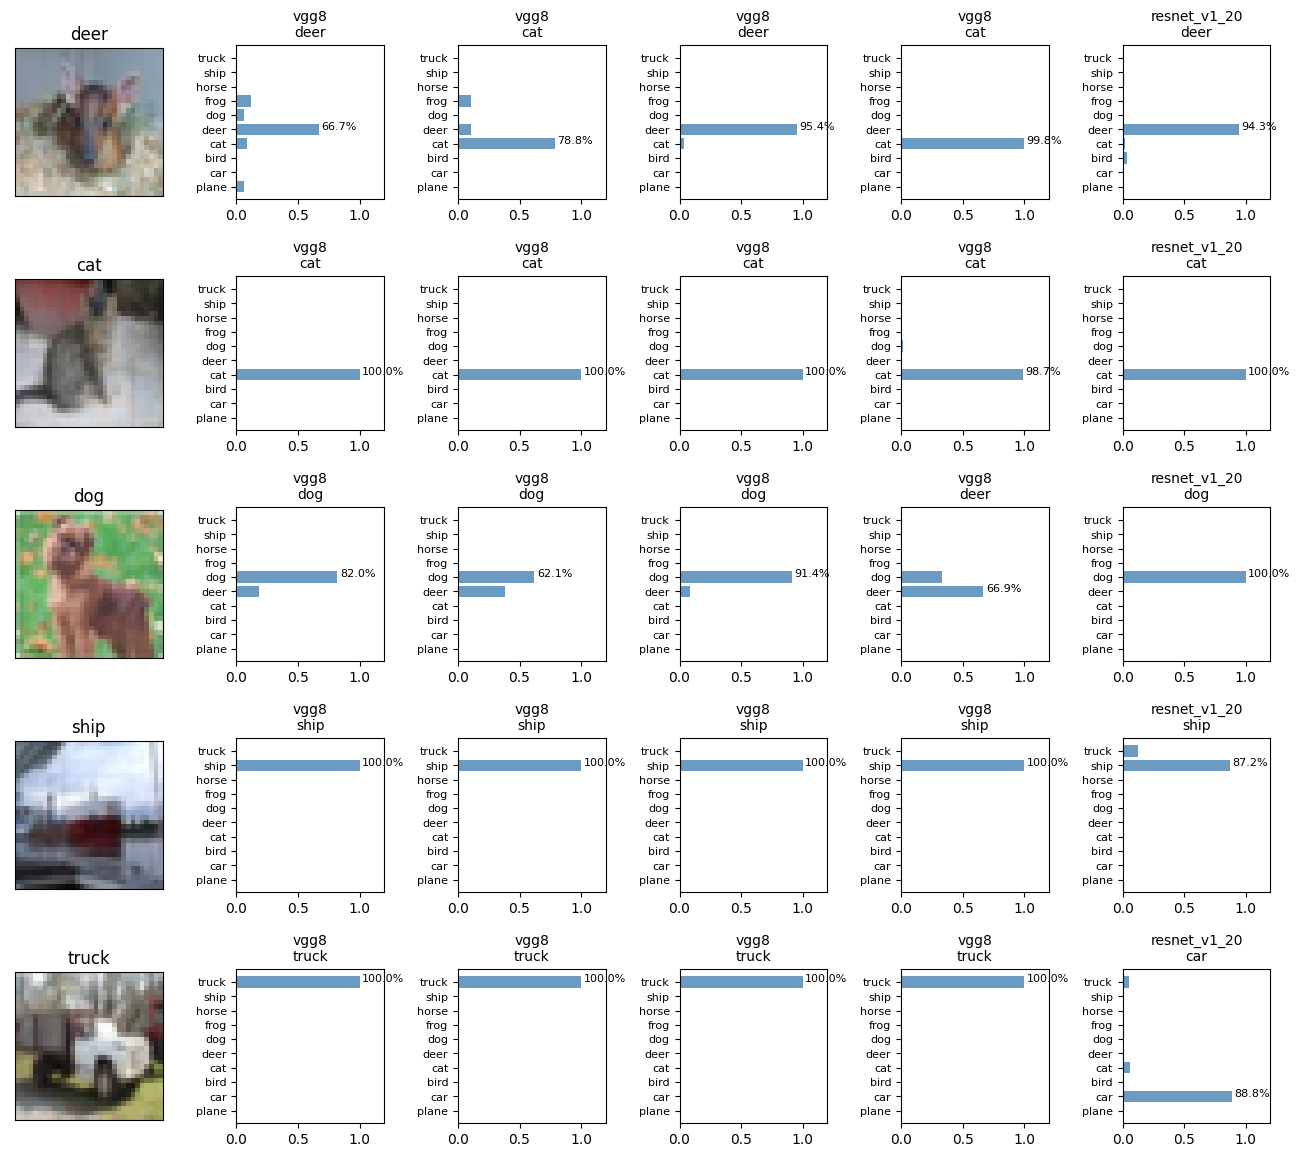

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 14ms/step


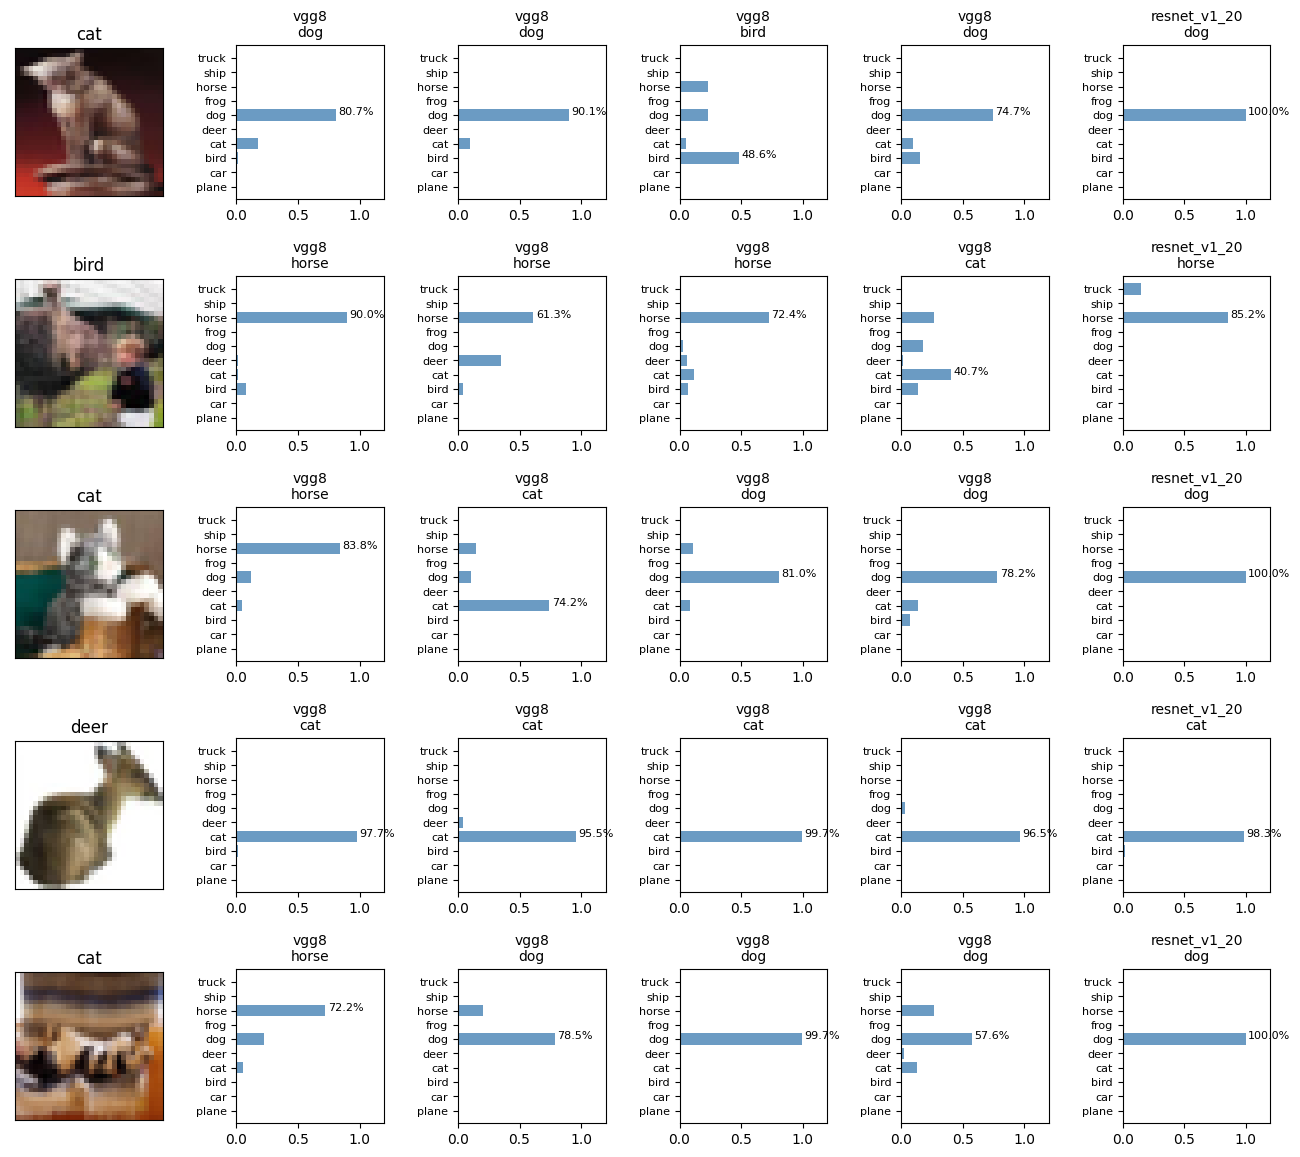

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 3ms/step
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 3ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



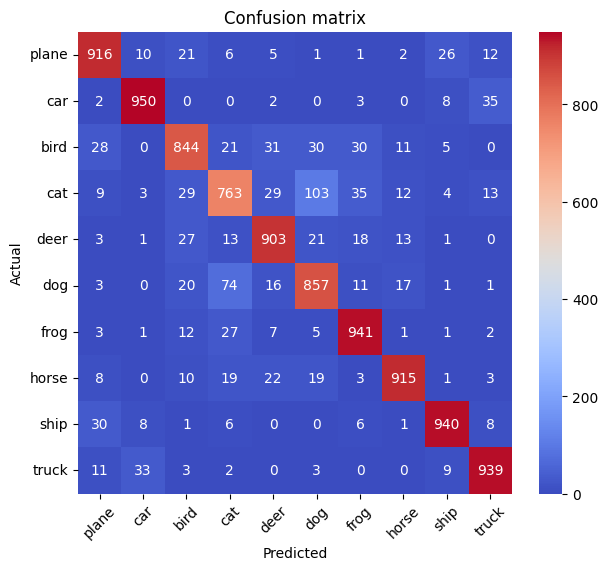

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset